# 1.2 Trajectory Tests

This document builds upon the foundation established in 1.1: Trajectory Analysis to achieve case-by-case trajectory results based off of different grain simulations. These simulations are computationally time- and storage-intensive, which has prevented me from displaying all of their results within the kernel. This was a major driver behind my decision to submit my paper primarily as a Word document, summarizing these data, and I would ask that you refer to that for a comprehensive and more time-effective summary. Alternatively, for your own sake, you can load this file up and go to the CUSTOM ZONE once the initial validation is run within this document. Once there, you can run any grain design you'd like by simply changing the getAX() function called.

This document also contains the validations for the simulation data fits, which was a significant point of discussion in the main paper.

## Import all variables and functions from previous files

In [20]:
row = 200 # Size of graph
col = row # Square Dimensions
exclude = -999
fuel = 100
burnt = 0
r0 = row/10
xCtr = h = int(row/2)
yCtr = k = int(col/2)



import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from numpy import pi
from PIL import Image
import time
plt.rcParams['axes.grid'] = True
pi = np.pi
C_D = 0.295 / 2 # Assumed to be the shape of a bullet + aerospike decreasing drag by 50% 
Tol = 0.1
Diameter = D = 2.11 # Outer diameter of first stage (assumed low thickness such that D_inner ~ D)
Radius = Rad = D / 2 # Abbreviated as Rad instead of R, which is the gas constant
Z = 6.720 # height of first stage in meters
A = pi * Rad**2 # Area of rocket interior, equivalent as well to the frontal surface area of the rocket
S_Mass = 59068 # kg, mass of the fuelled rocket with all three stages
S1_Mass = 37918 # kg, mass of the fuelled first stage
Fuel_Fraction = 0.616 # Fractional share of entire FUELLED rocket's mass by first stage fuel
MFuel_0 = Fuel_Fraction * S_Mass # Starting fuel mass of first stage
m = S1E_Mass = S1_Mass - MFuel_0 # Mass of empty fuel stage 
rho_P = MFuel_0 / (Z * np.pi * Radius **2)
T_C = 1600
MWEff = 36385 / 1190 # Total mass of propellant divided by the effective MW of gas exiting the nozzle, kmol
k_v = 1.15431 # Calculated using C_P and C_S values from JANAF
P_C = 6890.1 # Chamber pressure, kPa
P_0 = 101.325 # Atmospheric pressure, kPa
a = 1.26 # Constant for pressure
n = 0.4 # Exponent for pressure


rate = a / (100 * (100)**n * (1000)**n) * (P_C)**n

R = 8314 # J / kmol K
U_E = -np.sqrt(2 * T_C * (R/MWEff)*(k_v/(k_v - 1))*(1 - (P_0/P_C)**((k_v - 1)/k_v)))

print("Burn Rate: (m/s)", rate)
print("Exit Velocity (m/s):", U_E)


Burn Rate: (m/s) 0.004321761090596145
Exit Velocity (m/s): -1675.140347493681


In [28]:
def gravFunc(h):
    G_Constant = 6.67430 * 10**(-11) # m^3 / kg / s^2
    M_Earth = 5.972 * 10**24 # Kilograms
    R_Earth = 6371009 # Meters
    return G_Constant * M_Earth / (R_Earth + h)**2

def atmRhoFunc(h, ρ0=1.225):
    return ρ0 * np.exp(-1e-04*h)

def adj(a, y, x, checkVal):
    Dirs = [[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1],[-1,0],[-1,1]]
    Borders = []
    for Dir in Dirs:
        if a[y + Dir[0]][x + Dir[1]] > checkVal:
            Borders.append([y + Dir[0], x + Dir[1]])
    
    return Borders

def burnTedious(a, rate, threshold=85, multiplier=1):
    burningMap = np.zeros((row, col))
    
    for i in range(col):
        for j in range(row):
            if a[j][i] < threshold and a[j][i] != exclude:
                borderingVals = adj(a, j, i, 0)
                for val in borderingVals:
                    a[val[0]][val[1]] -= rate * multiplier
                    burningMap[val[0]][val[1]] = 100
    return a, burningMap

def Clean(a, V):
    Ly, Lx = len(a[:][0]), len(a[0][:])
    for i in range(Ly):
        a[i][0] = V
        a[i][-1] = V
    for j in range(Lx):
        a[0][j] = V
        a[-1][j] = V
    return a

def Circle(a, h, k, r0, val, prints = False):
    for c in range(col):
        for r in range(row):
            if c >= h - r0 and c <= h + r0:
                ylimH = k + np.sqrt(r0**2 - (c - h)**2)
                ylimL = k - np.sqrt(r0**2 - (c - h)**2)
                if r <= ylimH and r >= ylimL:
                    a[r][c] = val
    if prints == True:
        print("Starting Propellant Shape:")
        fig = plt.figure(figsize=(3,3))
        im = plt.imshow(Drawing, interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=100)
        plt.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False) 
        plt.show()
    return a
def line(a, p1, p2, val, prin=False):
    y2, y1 = p2[0], p1[0]
    x2, x1 = p2[1], p1[1]
    Δx, Δy = x2 - x1, y2 - y1
    h = np.sqrt(Δx**2 + Δy**2)
    θ = np.arctan2(Δx, Δy)
    x_in, y_in, i = x1, y1, 0
    
    x_wasless = False
    y_wasless = False
    x_wasmore = False
    y_wasmore = False
    
    while int(round(x_in, 0)) != int(round(x2,0)) or int(round(y_in,0)) != int(round(y2, 0)):
        x_in = x1 + i * np.sin(θ)
        y_in = y1 + i * np.cos(θ)
        x = x1 + (i - 1) * np.sin(θ)
        y = y1 + (i - 1) * np.cos(θ)
        
        if abs(x) < abs(x2):
            x_wasless = True
        if abs(x) > abs(x2):
            x_wasmore = True
        if abs(y) < abs(y2):
            y_wasless = True
        if abs(y) > abs(y2):
            y_wasmore = True
            
        if (x_wasless and x_wasmore) or (y_wasless and y_wasmore):
            break
            
        if prin == True:
            print(int(round(x_in, 0)), int(round(x2,0)), int(round(y_in,0)),int(round(y2, 0)))
        if int(y_in) < row and int(x_in < col):
            a[int(y_in)][int(x_in)] = val
        elif int(y_in) < row:
            a[int(y_in)][row] = val
        elif int(x_in) < col:
            a[col][int(x_in)] = val

        i += 1
    return a
def triangle(a, xc, yc, b, h, angle, val, prin=False):
    a[yc][xc] = 50
    angle = np.radians(angle)
    θ_a = pi/2 - angle
    A = [yc + 1/2 * h * sin(θ_a), xc + 1/2 * h * cos(θ_a)]
    B = [yc - 1/2 * h * sin(θ_a) - 1/2 * b * sin(angle), xc + 1/2 * b * cos(angle) - 1/2 * h * cos(θ_a)]
    C = [yc - 1/2 * h * sin(θ_a) + 1/2 * b * sin(angle), xc - 1/2 * h * cos(θ_a) - 1/2 * b * cos(angle)]
    a = line(a, A, B, val)
    a = line(a, B, C, val)
    a = line(a, C, A, val)
    AY = int(A[0])
    AX = int(A[1])
    BY = int(B[0])
    BX = int(B[1])
    CY = int(C[0])
    CX = int(C[1])
    '''
    if AY < row and AX < col:
        a[AY, AX] = val
    if BY < row and BX < col:
        a[BY, BX] = val
    if CY < row and CX < col:
        a[CY, CX] = val
    '''
    return a

def Rectangle(a, cx, cy, lt, ht, θ, val):
    # a = array to modify
    # cx = x-center of rectangle
    # cy = y-center of rectangle
    # lt = length of rectangle
    # ht = height of rectangle
    lx = len(a[0][:])
    ly = len(a[:][0])
    # Find corners
    θ = np.radians(θ)
    R = np.sqrt(1/4*lt**2 + 1/4 * ht ** 2)
    Θ = θ + np.arctan2(ht, lt)
    ΘB = θ - np.arctan2(ht, lt)
    TL = [cy + R*sin(Θ), cx - R*cos(Θ)]
    BR = [cy + R*sin(-Θ), cx + R*cos(-Θ)]
    BL = [cy + R*sin(ΘB), cx - R*cos(ΘB)]
    TR = [cy - R*sin(ΘB), cx + R*cos(ΘB)]


    yMax = max(TL[0], TR[0], BL[0], BR[0])
    xMax = max(TL[1], TR[1], BL[1], BR[1])
    yMin = min(TL[0], TR[0], BL[0], BR[0])
    xMin = min(TL[1], TR[1], BL[1], BR[1])
    
    a = line(a, BL, TL, val)
    a = line(a, BR, TR, val)
    a = line(a, TL, TR, val)
    a = line(a, BR, BL, val)
    
    return a
def Bar(a, width, θ, cx, cy, c, ex, length=row, symmetric=False):
    Ly, Lx = len(a[:][0]), len(a[0][:])
    #cy, cx = int(Ly/2), int(Lx/2)
    θ = np.radians(θ)
    cancelx, cancely, invert = 1, 1, 1
    for k2 in range(1 + symmetric):
        for k in range(-width, width):
            if k2 == 1:
                invert = -1
            if θ >= np.pi / 4:
                cancely = 0
            else:
                cancelx = 0
            iF, jF = cy + k * cancely, cx + k * cancelx
            i, j = int(iF), int(jF)
            n = 0
            while a[i][j] != ex and i < (Ly) and j < (Lx) and n < length:
                a[i][j] = c
                a[i][j] = c
                jF, iF, j, i = barStep(jF, iF, θ, invert)
                n+=1
    return a
def barStep(jF, iF, θ, invert):
    jF+=1*cos(θ) * invert
    iF+=1*sin(θ) * invert
    j = int(jF)
    i = int(iF)
    return jF, iF, j, i
def cos(x):
    return np.cos(x)
def sin(x):
    return np.sin(x)
def Fill(a, xCtr, yCtr, b, h, angle, Function, valo):
    for i in [0, 1, -1]:
        bTrack = b
        hTrack = h
        while bTrack >= 0:
            a = Function(a, xCtr + i, yCtr, bTrack, h, angle, valo)
            bTrack -= 1
    return a

def mapFromNumpyData(numpyData):
    a = exclude * np.ones((row + 1, col + 1))
    j = 0
    i = 0
    for color in numpyData:
        i = 0
        for pixel in color:
            if pixel[0] - 0 == 0 and pixel[1] - 255 == 0 and pixel[2] - 255 == 0:
                a[j][i] = -999
            elif pixel[0] - 128 == 0 and pixel[1] - 128 == 0 and pixel[2] - 128 == 0:
                a[j][i] = 100
            elif pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
                a[j][i] = 0
            else:
                a[j][i] = 50
            i += 1
        j += 1

    return a

def getA1():
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, h, k, row/2, fuel) # Define propellant at value = 100
    a = Circle(a, h, k, r0, burnt) # Define hollow center at value = 0
    a = Clean(a, exclude)
    return a
def getA2():
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, h, k, row/2, fuel) # Define propellant at value = 100
    a = Circle(a, h, k, r0*3, burnt) # Define hollow center at value = 0
    a = Circle(a, h, k, r0*2.5, fuel) # Define filled center at value = 0
    a = Clean(a, exclude)
    return a
def getA3():
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, h, k, row/2, 100) # Define propellant at value = 100
    a = Bar(a, 3, 90, h, k, 0, exclude, symmetric=True) # Define spaces at value = 0
    a = Bar(a, 3, 0, h, k, 0, exclude, symmetric=True) # Define spaces at value = 0
    a = Clean(a, exclude)
    return a
def getA4():
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, h, k, row/2, fuel) # Define propellant at value = 100
    b = 40
    shift = -5
    ht = 12
    width = 5
    a = Fill(a, xCtr - 10 + shift, yCtr, b/2, ht, 0, Rectangle, 0)
    a = Fill(a, xCtr - 0 + shift, yCtr + 15, b/2, ht/1.5, 72, Rectangle, 0)
    a = Fill(a, xCtr + 15 + shift, yCtr + 10, b/2, ht/1.5, 144, Rectangle, 0)
    a = Fill(a, xCtr + 15 + shift, yCtr - 5, b/1.3, ht/1.5, 144 + 72, Rectangle, 0)
    a = Fill(a, xCtr - 0 + shift, yCtr - 10, b/1.3, ht/1.5, 144 + 72 + 72, Rectangle, 0)
    a = Clean(a, exclude)
    return a
def getA5():
    ht = 18
    b = 60
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, h, k, row/2, fuel) # Define propellant at value = 100
    a = Circle(a, h, k, r0*3.5, burnt) # Define hollow center at value = 0
    n = 6
    angle = 360/n
    yPos = [100, 50, 50, 100, 150, 150]
    xPos = [160, 130, 70, 40, 70, 130]
    yPos2 = [100-35, 50-15, 50+15, 100+35, 150+15, 150-15]
    xPos2 = [160, 130-30, 40, 40, 100, 160]
    for rect in range(n):
        a = Fill(a, xPos[rect], yPos[rect], b, ht, angle * rect, Rectangle, 100)
        a = Fill(a, xPos2[rect], yPos2[rect], b*2/3, ht, angle * rect + 30, Rectangle, 100)
    a = Clean(a, exclude)

    a = Fill(a, xCtr-22, yCtr, 18, 10, 90, triangle, 100)
    a = Fill(a, xCtr+22, yCtr, 18, 10, -90, triangle, 100)
    a = Fill(a, xCtr-12, yCtr - 20, 18, 10, 30, triangle, 100)
    a = Fill(a, xCtr+12, yCtr - 20, 18, 10, -30, triangle, 100)
    a = Fill(a, xCtr-12, yCtr + 20, 18, 10, 150, triangle, 100)
    a = Fill(a, xCtr+12, yCtr + 20, 18, 10, -150, triangle, 100)
    return a
def getA6():
    a = exclude * np.ones((row + 1, col + 1))
    a = Circle(a, xCtr, yCtr, row/2, fuel) # Define propellant at value = 100
    a = Circle(a, xCtr, yCtr, row/3.0, burnt) # Define propellant at value = 100
    b = 120
    h = 120
    a = Fill(a, xCtr + 65, yCtr, b, h, 90, triangle, 100)
    a = Fill(a, xCtr - 65, yCtr, b, h, -90, triangle, 100)
    a = Circle(a, xCtr, yCtr, row/25, burnt) # Define propellant at value = 100
    a = Clean(a, exclude)
    return a

def getA7():
    numpydata = np.asarray(Image.open('Imported-Finger.png'))
    a = mapFromNumpyData(numpydata)
    return a
def getA8():
    numpydata2 = np.asarray(Image.open('Imported-Spiral.png'))
    a = mapFromNumpyData(numpydata2)
    return a
def getA9():
    numpydata = np.asarray(Image.open('Imported-Utah.png'))
    a = mapFromNumpyData(numpydata)
    return a
def getA10():
    numpydata = np.asarray(Image.open('Import-Feathers.png'))
    a = mapFromNumpyData(numpydata)
    return a
def getA11():
    numpydata = np.asarray(Image.open('Imported-Finisher.png'))
    a = mapFromNumpyData(numpydata)
    return a
def getA12():
    numpydata = np.asarray(Image.open('Import-Baseball.png'))
    a = mapFromNumpyData(numpydata)
    return a

def plotter(datas, times, labs, index=0, xlab=" ", ylab=" ", legend=True, hlines=[], vlines=[], tmn = 0, tmx = 0, show=True, Title=" "):
    if tmx == 0:
        tmx = len(times)
    
    for line in hlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axhline(y=line, color=co, lw=width, linestyle=style)
    for line in vlines:
        if line == 0:
            co, width, style = 'k', 1, "solid"
        else:
            co, width, style = 'b', 1, "dashed"
        plt.axvline(y=line, color=co, lw=width, linestyle=style)
    n = 0
    for datum in datas:
        plt.plot(times[tmn:tmx], datum[:,index][tmn:tmx]/1000, label=labs[n])
        n += 1
    if legend == True:
        plt.legend()
    if xlab != " " or ylab != " ":
        plt.xlabel(xlab)
        plt.ylabel(ylab)
    if Title != " ":
        plt.title(Title)
    if show == True:
        plt.show()
        
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

def plotCourse(snapshots, n_trials):
    fig, axarr = plt.subplots(nrows=1,ncols=4, figsize=(18,4), dpi=50)
    plt.sca(axarr[0])
    im = plt.imshow(snapshots[0], interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=fuel, origin='lower')
    plt.sca(axarr[1])
    im = plt.imshow(snapshots[int(n_trials/4)], interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=fuel, origin='lower')
    plt.sca(axarr[2])
    im = plt.imshow(snapshots[int(n_trials/2)], interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=fuel, origin='lower')
    plt.sca(axarr[3])
    im = plt.imshow(snapshots[-1], interpolation='none', aspect='auto', cmap="hot", vmin=0, vmax=fuel, origin='lower')
    plt.show()
    

In [30]:
alt = np.logspace(0, 8, 56)
gravdata = gravFunc(alt)
rhodata = atmRhoFunc(alt)
FoundG = False
FoundD = False
for i in range(len(gravdata)):
    if gravdata[i] < gravdata[0]/10 and FoundG == False:
        P01PointGrav = alt[i]
        FoundG = True
    if rhodata[i] < rhodata[0] / 100 and FoundD == False:
        P001PointRho = alt[i]
        FoundD = True
    if FoundD and FoundG:
        break
        

## Include analytical, simulation, and Forward Euler functions

In [33]:
# Import the three analytical functions

def tubular(r0, rate, rmax, time):
    A = (Z * 2 * pi * (r0 + time * rate))
    if A >= Z * 2 * pi * Rad:
        A = 0
    return A

def cross(r0, rate, rmax, time, bevel=True):
    if bevel == True:
        BEVEL =  np.sqrt(2 * rate**2 * time**2) - rate * time
    else:
        BEVEL = 0
    if 1-(r0 / 5 + time * rate)**2/Rad**2 > 0:
        A = 8 * Z * Rad * (np.sqrt(1-(r0 / 5 + time * rate)**2/Rad**2) - (r0 + rate * time) / Rad + BEVEL)
    else:
        A = 0
    if A < 0:
        A = 0
    return A

def rod_and_tube(r0, rate, rmax, time):
    margin = 2.55
    
    RA0 = r0*margin
    RB0 = r0*(margin - .1)
    P1 = 2 * pi * ((RA0) + rate*time) 
    P2 = 2 * pi * ((RB0) - rate*time)

    if P1 >= 2 * pi * Rad:
        P1 = 0    
    if P2 < 0:
        P2 = 0
    A = Z * (P1  + P2)
    return A

# Import the simulation functions

def burnAnalysis(a, r, tmax=1600):
    import time
    snapshots, burns, clock, Simtimes = [], [], [], []
    alast, anow, n_trials = 0, 1, 0
    while n_trials < tmax and alast != anow:
        print(n_trials, end='\r')
        start_time, alast = time.time(), sum(sum(a))
        a, burningMap = burnTedious(a, r)
        clock.append(time.time() - start_time)
        burns.append(burningMap)
        snapshots.append(a.copy())
        Simtimes.append(n_trials)
        anow = sum(sum(a))
        n_trials += 1
    return snapshots, burns, n_trials

def burns_to_areas(burns):
    surface, ns, Simtimes = [], [], []
    for snap in burns:
        xbord, ybord = np.where(snap > 0)
        surface.append(len(xbord))
    return surface


---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

## Run validation of analytical model to simulation
##### We begin by selecting one of the known analytical models (A1, A2, or A3) and running its corresponding map through the burn analysis

A1, the tubular model, should conclude at n = 1131

In [38]:

rate_pixel = rate * row / 2.11
a = getA1()
snapshots, burns, n_trials = burnAnalysis(a, rate_pixel)

#### Verify that the burn progression looks somewhat reasonable.

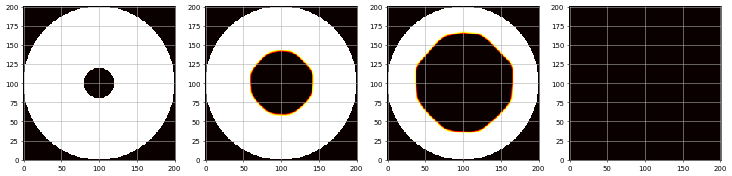

In [40]:
surface = burns_to_areas(burns)
Simtimes = np.arange(0, n_trials, 1)

Simtimes = np.array(Simtimes)
surface = np.array(surface)

plotCourse(snapshots, n_trials)

#### Next, run the analytical model

In [43]:
areaTimes = np.arange(0, 250, .1)
tubularAreas = []
for time in areaTimes:
    tubularAreas.append(tubular(D/10, rate, D/2, time))

#### We will now fit the simulation to the analytical model.

The simulation has been run with an assumed burn rate, but this alone is insufficent to estimate the magnitude or duration of the burn. To maintain sanity in our simulation, we will scale the time and surface area axes to best fit the analytical solution. The scale we choose for this one will apply to all other designs.

In [46]:
FtimeScale = 4.8
surfaceScale = 50
#timeScale = 1
#surfaceScale = 1

Text(0.5, 0, 'Time (s)')

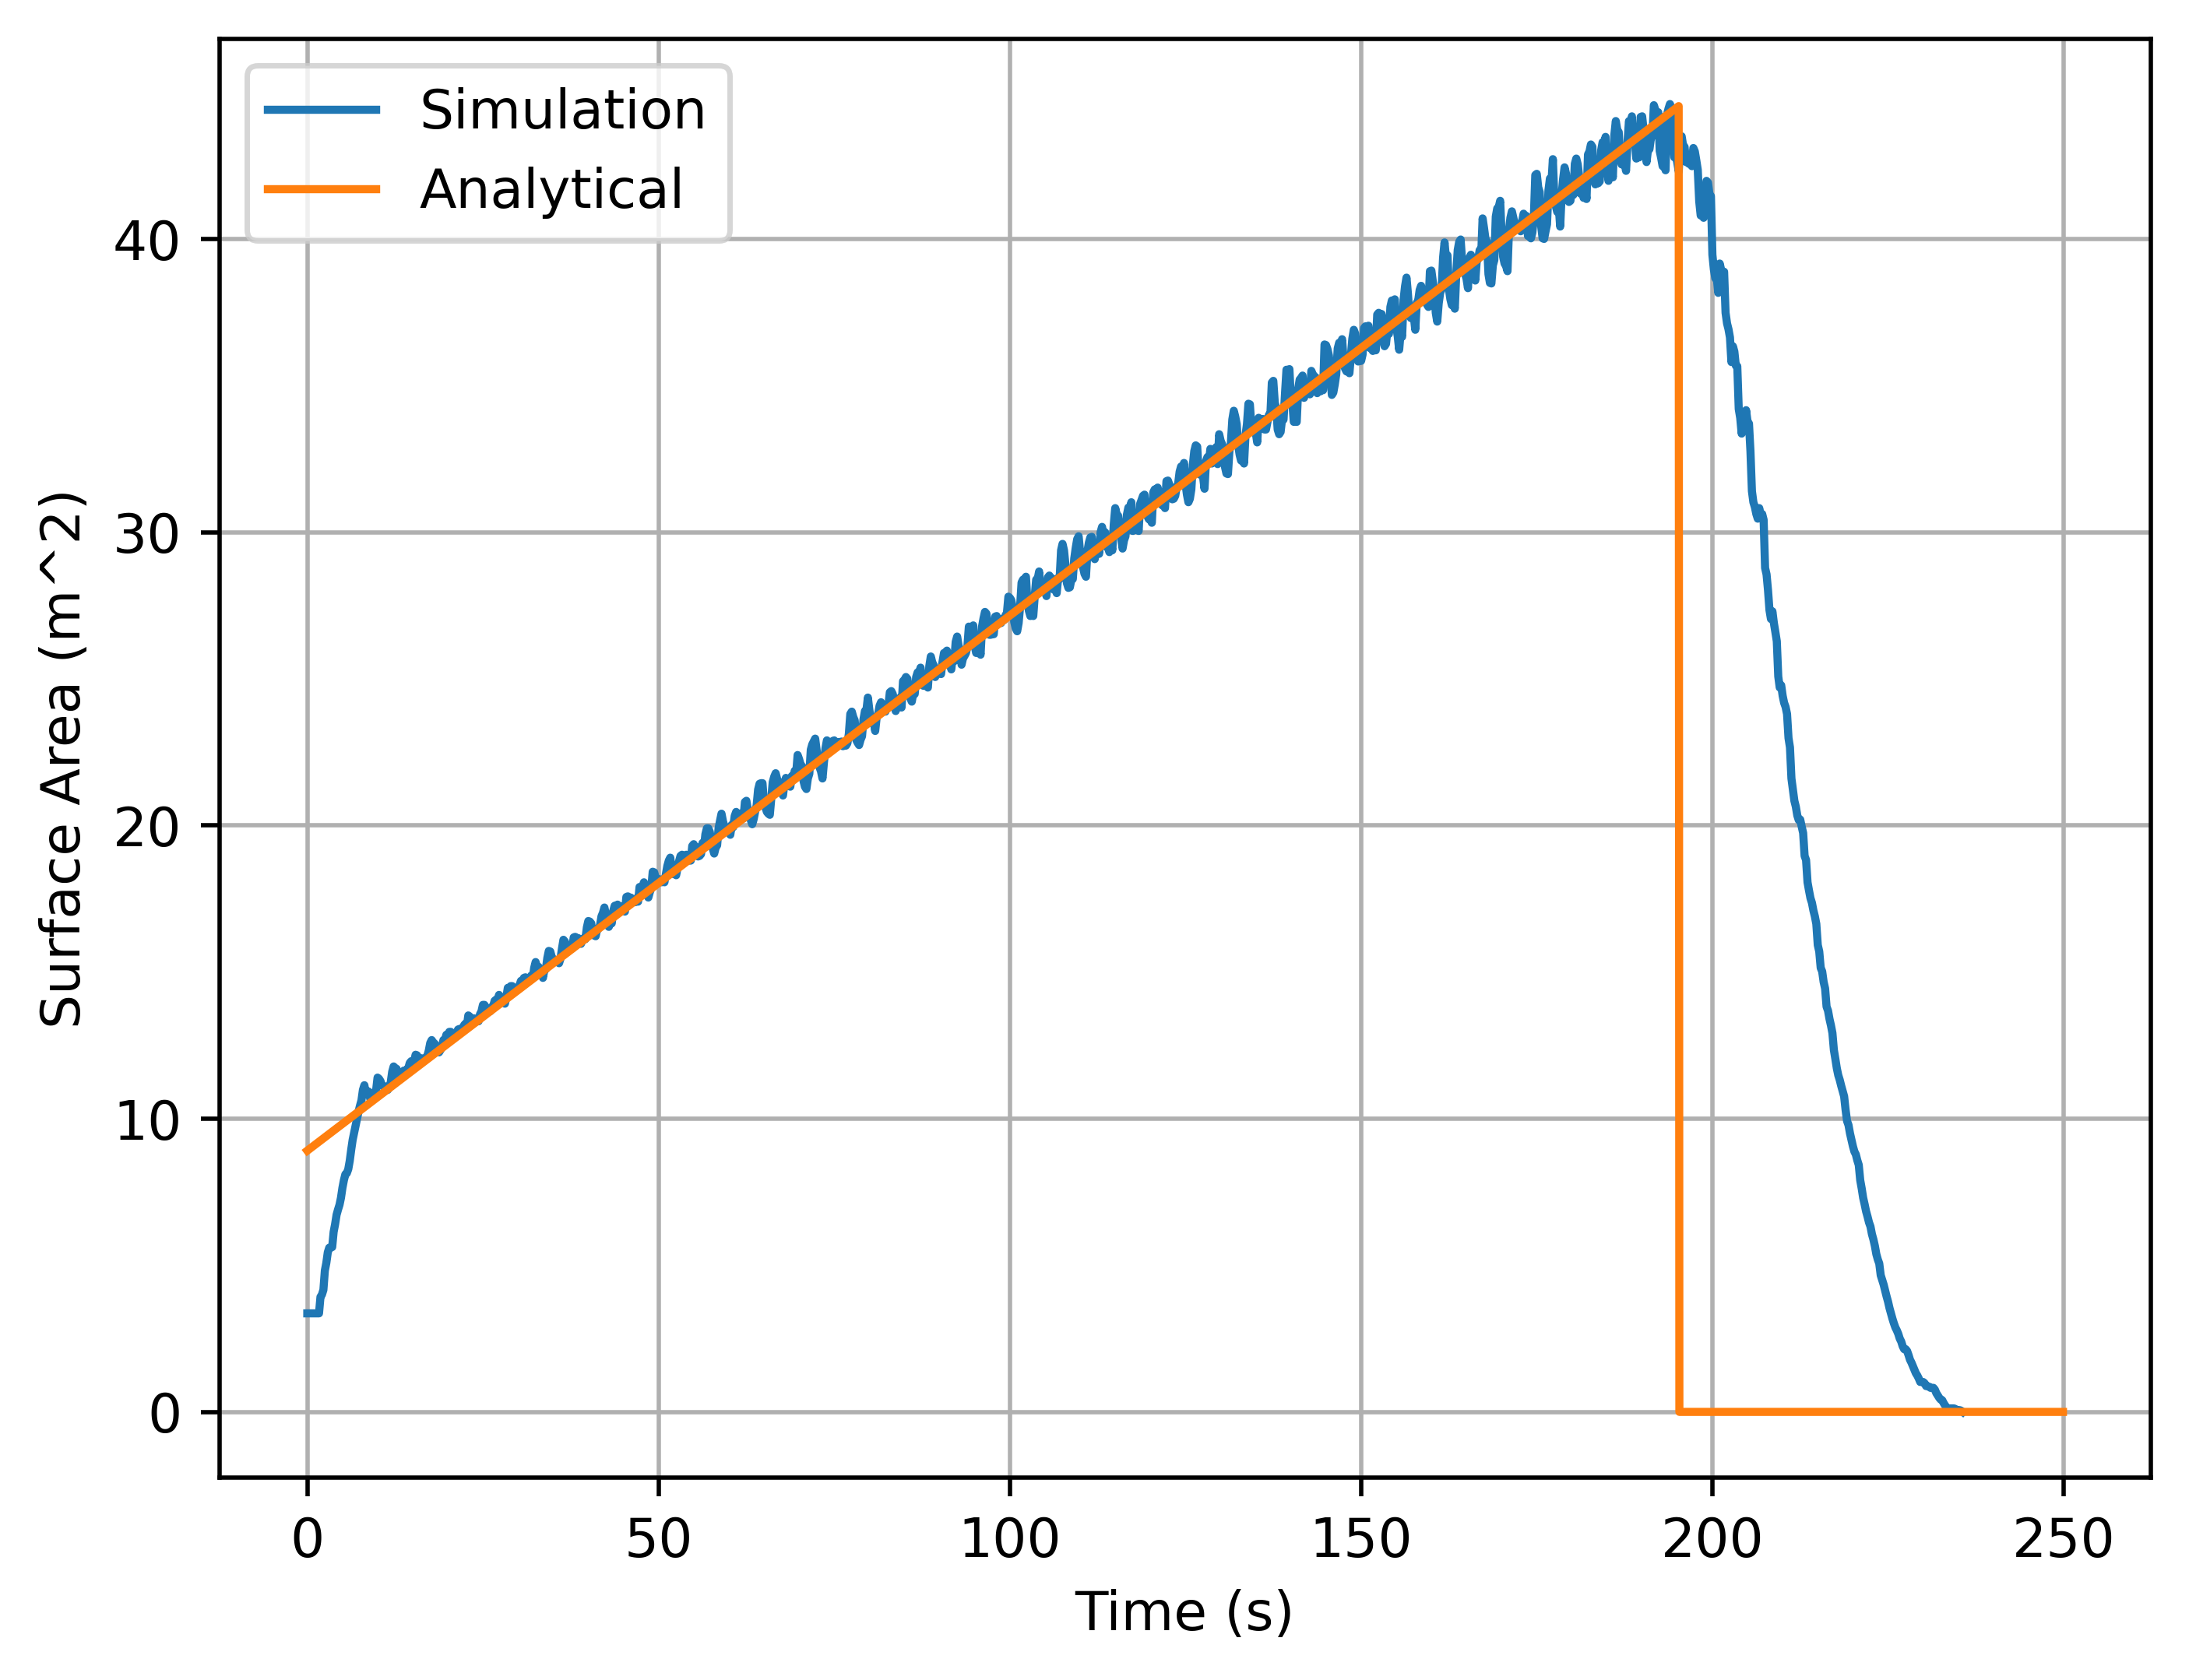

In [48]:
plt.rcParams['figure.dpi'] = 500
Sim_interp_x = interp1d(np.asarray(Simtimes/timeScale), new_len=400)
Sim_interp_y = interp1d(np.asarray(surface/surfaceScale), new_len=400)
plt.plot(Simtimes/timeScale, surface/surfaceScale, label = "Simulation")
#plt.plot(Sim_interp_x, Sim_interp_y, label = "Simulation Interpolated")
plt.plot(areaTimes, tubularAreas, label = "Analytical")
plt.legend()
plt.ylabel("Surface Area (m^2)")
plt.xlabel("Time (s)")

# Simulations

This section is dedicated to testing and comparing trajectories for different rocket designs

## Set general parameters

In [50]:
tmin = 0
tmax = 1600
inc = 0.2
times = np.arange(0, int(tmax), inc)

starting_r = D/10

h_0 = 0
V_0 = 5
M_0 = S1_Mass - pi * starting_r**2 * Z * rho_P
Mf_0 = MFuel_0 - pi * starting_r**2 * Z * rho_P

IV = [h_0, V_0, M_0, Mf_0]
print(IV)

[0, 5, 36462.56448, 34930.45248]


In [52]:

# Import the Forward Euler function

def forward(f, times, IV, Areas, sim=False):
    print("FE Start")
    n = len(times)
    m = len(IV)
    data = np.zeros((n, m))
    data[:][0] = IV
    fuelzero = False
    for i in range(n - 1):
        dt = times[1] - times[0]
        data[:][i+1] = data[:][i] + dt * f (times[i], data[:][i], Areas, fuelzero, i, sim)
        if data[:][i+1][3] < 0: # Account for fuel levels dropping below 0
            data[:][i+1][3] = 0
            fuelzero = True
        if data[:][i+1][1] < 0 and data[:][i+1][0] < 5: # Kill negative velocities if below a groundlevel threshhold
            data[:][i+1][1] = 0
        if data[:][i+1][0] < 0: # Kill negative altitudes if below a groundlevel threshhold
            data[:][i+1][0] = 0  
    print("FE Complete")
    return data

In [54]:
def model(t, vals, Areas, fuelzero, n, sim):
    '''
    if t == 0:
        print(np.array(Areas)[1, :])
        print(np.array(Areas)[0, :])
        print("Interp at t = 30 = ", np.interp(30, np.array(Areas)[0, :], np.array(Areas)[1, :]))
    '''
    #print("Time:", int(t), "________________", end='\r')
    h = vals[0]
    V = vals[1]
    M = vals[2]
    Mf = vals[3]
    g = gravFunc(h)
    ρ = atmRhoFunc(h)
    if ρ > atmRhoFunc(0):
        ρ = atmRhoFunc(0)
    elif ρ < 0:
        ρ = 0
    if g > gravFunc(0):
        g = gravFunc(0)
    elif g < 0:
        g = 0
    
    if sim == False:
        Surface_Area = np.array(Areas)[1,n]
    elif sim == True:
        if t < max(np.array(Areas)[0, :]):
            Surface_Area = np.interp(t, np.array(Areas)[0, :], np.array(Areas)[1, :])
            #print("A = ", Surface_Area, t)
        else:
            Surface_Area = 0
    hdot = V
    if fuelzero == False:
        mDot = -rho_P * Surface_Area * rate
        
    else:
        mDot = 0
    Vdot = -g - 1/2 * ρ * V * abs(V) * C_D * A / M + mDot * U_E / M

    mfDot = mDot
    
    
    return np.array([hdot, Vdot, mDot, mfDot], dtype=object)

def conductTest(a, snapshots, burns, n_trials, titleInsert=" ", group=" "):
    surface = burns_to_areas(burns)
    Simtimes = np.arange(0, n_trials, 1)

    Simtimes = np.array(Simtimes)
    surface = np.array(surface)

    plotCourse(snapshots, n_trials)
    scaledSurface = interp1d(surface/surfaceScale, new_len=400)
    scaledTimes = interp1d(Simtimes/timeScale, new_len=400)    

    plt.plot(scaledTimes, scaledSurface, label = group)

    plt.ylabel("Surface Area (m^2)")
    plt.xlabel("Time (s)")
    
    tubularAreas = []
    for t_it in times:
        tubularAreas.append(tubular(starting_r, rate, D/2, t_it))
    
    plt.plot(times, tubularAreas, label = "Analytical Tubular")
    plt.xlim(0, max(scaledTimes))
    plt.legend()
    plt.show()


    # SIMULATED TRAJECTORY

    Areas = [scaledTimes, scaledSurface]
    data = forward(model, times, IV, Areas, sim=True)

    Areas = [times, tubularAreas]
    data1 = forward(model, times, IV, Areas, sim=True)
    
    datas = [data, data1]
    labels = [group, "Analytical Tubular"]

    plotter(datas, times, labels, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
            hlines=[P001PointRho/1000, 0], vlines=[], tmn = 0, tmx = int(tmax/inc), Title=titleInsert)
    return data, [scaledTimes, scaledSurface]

---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------

# CUSTOM ZONE

Originally the goal was to lay out all of the different methods at once, but Jupyter crashed repeatedly and has forced me to take a different approach.

---------------------------------------------------------------------------------------------------------------------------------

In [58]:
tmin, tmax, inc, timeScale, surfaceScale, rate_pixel, starting_r = 0, 1600, 0.2, 4.8, 50, rate * row / 2.11, D/10
times = np.arange(0, int(tmax), inc)
h_0, V_0, M_0, Mf_0 = 0, 5, S1_Mass - pi * starting_r**2 * Z * rho_P, MFuel_0 - pi * starting_r**2 * Z * rho_P
IV = [h_0, V_0, M_0, Mf_0]



title = "My Sample"

aFunctions = {"Tubular": getA1, "Cyclinder" : getA2, "Cross" : getA3, "Star" : getA4, "MULTI1" : getA5, "IRON" : getA6, "MULTI2": getA7, "SPIRAL": getA8, "UTAH" : getA9, "FEATHER" : getA10, "DREAMCATCHER" : getA11, "BASEBALL" :  getA12}
a = aFunctions["Tubular"]()
AXsnaps, AXburns, AXn = burnAnalysis(a, rate_pixel)

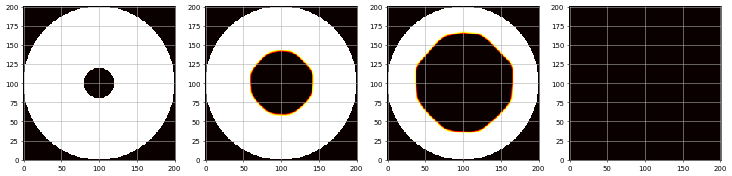

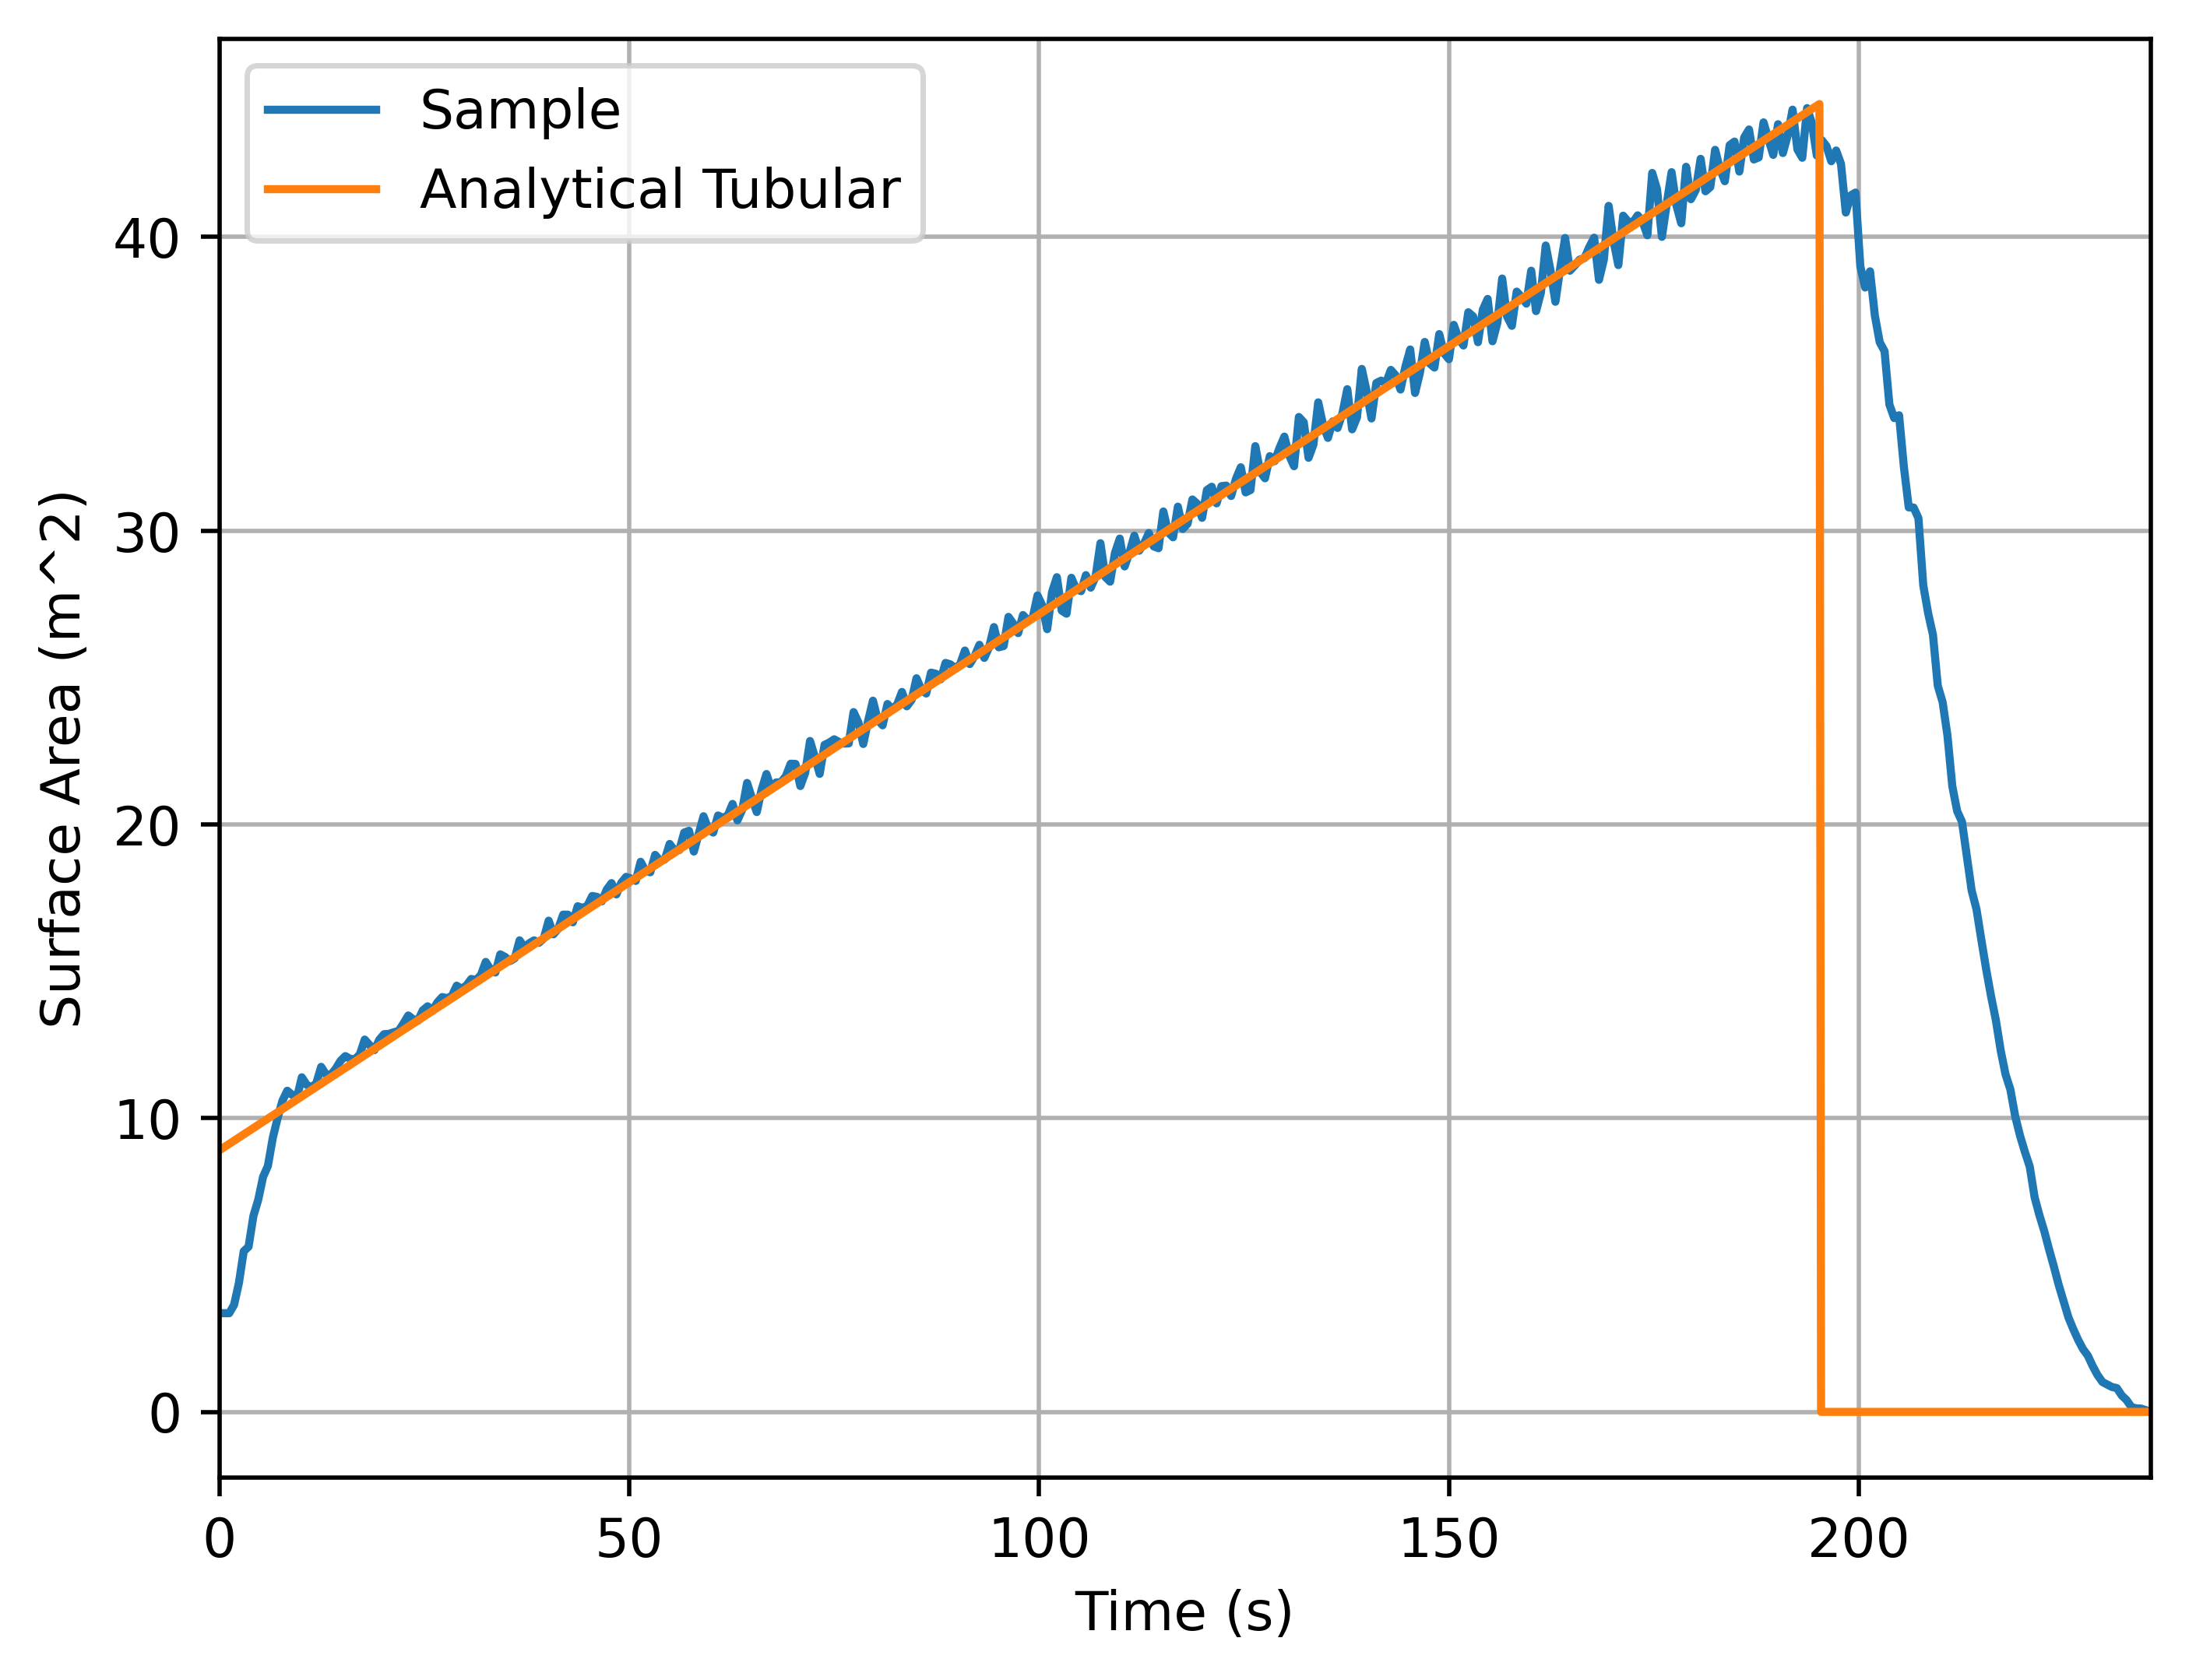

FE Start
FE Complete
FE Start
FE Complete


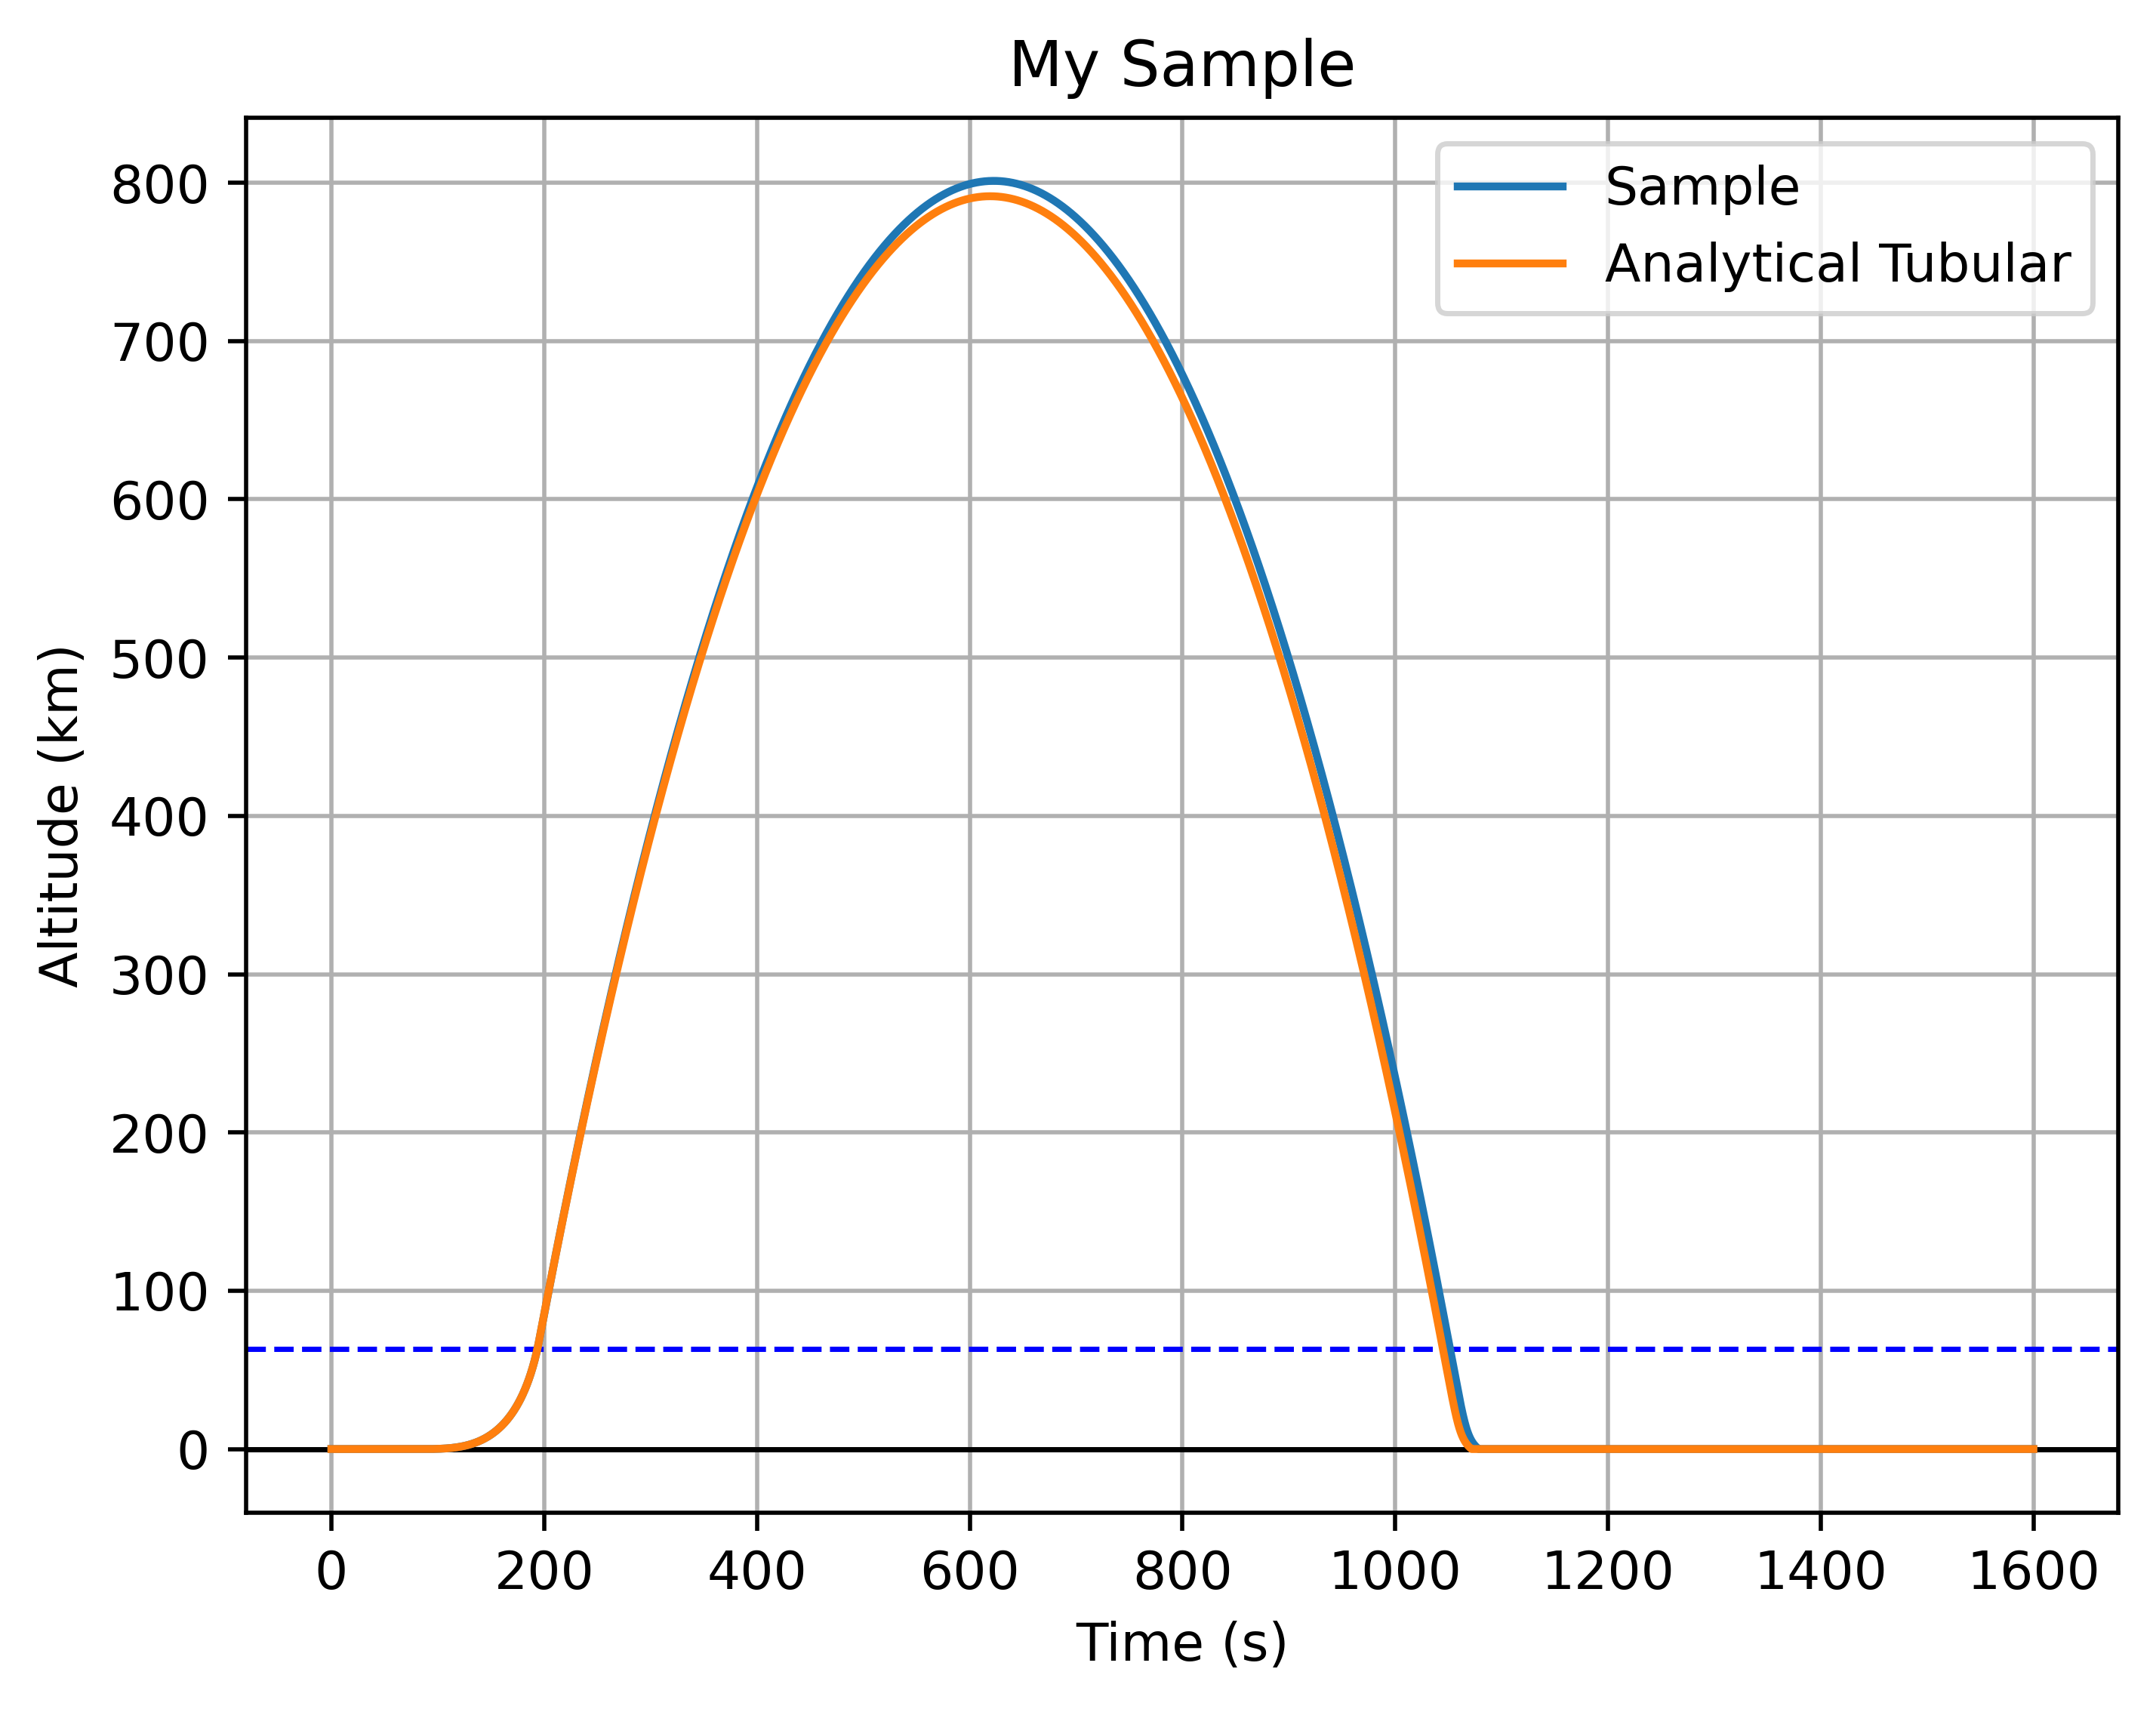

In [59]:
data_AX_SIM, simAXResults = conductTest(a, AXsnaps, AXburns, AXn, titleInsert=title, group="Sample")

In [15]:
np.savetxt('Baseball.csv', (times, data_AX_SIM[:, 0]), delimiter=',')

### Simulation 1: Validating Trajectories for Tubular Designs

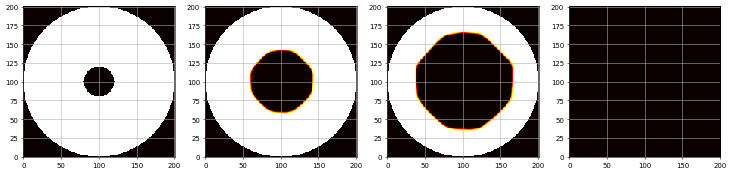

In [16]:
burns = []
a = getA1()
snapshots, burns, n_trials = burnAnalysis(a, rate_pixel)
surface = burns_to_areas(burns)
Simtimes = np.arange(0, n_trials, 1)

Simtimes = np.array(Simtimes)
surface = np.array(surface)

plotCourse(snapshots, n_trials)

FE Start
FE Complete


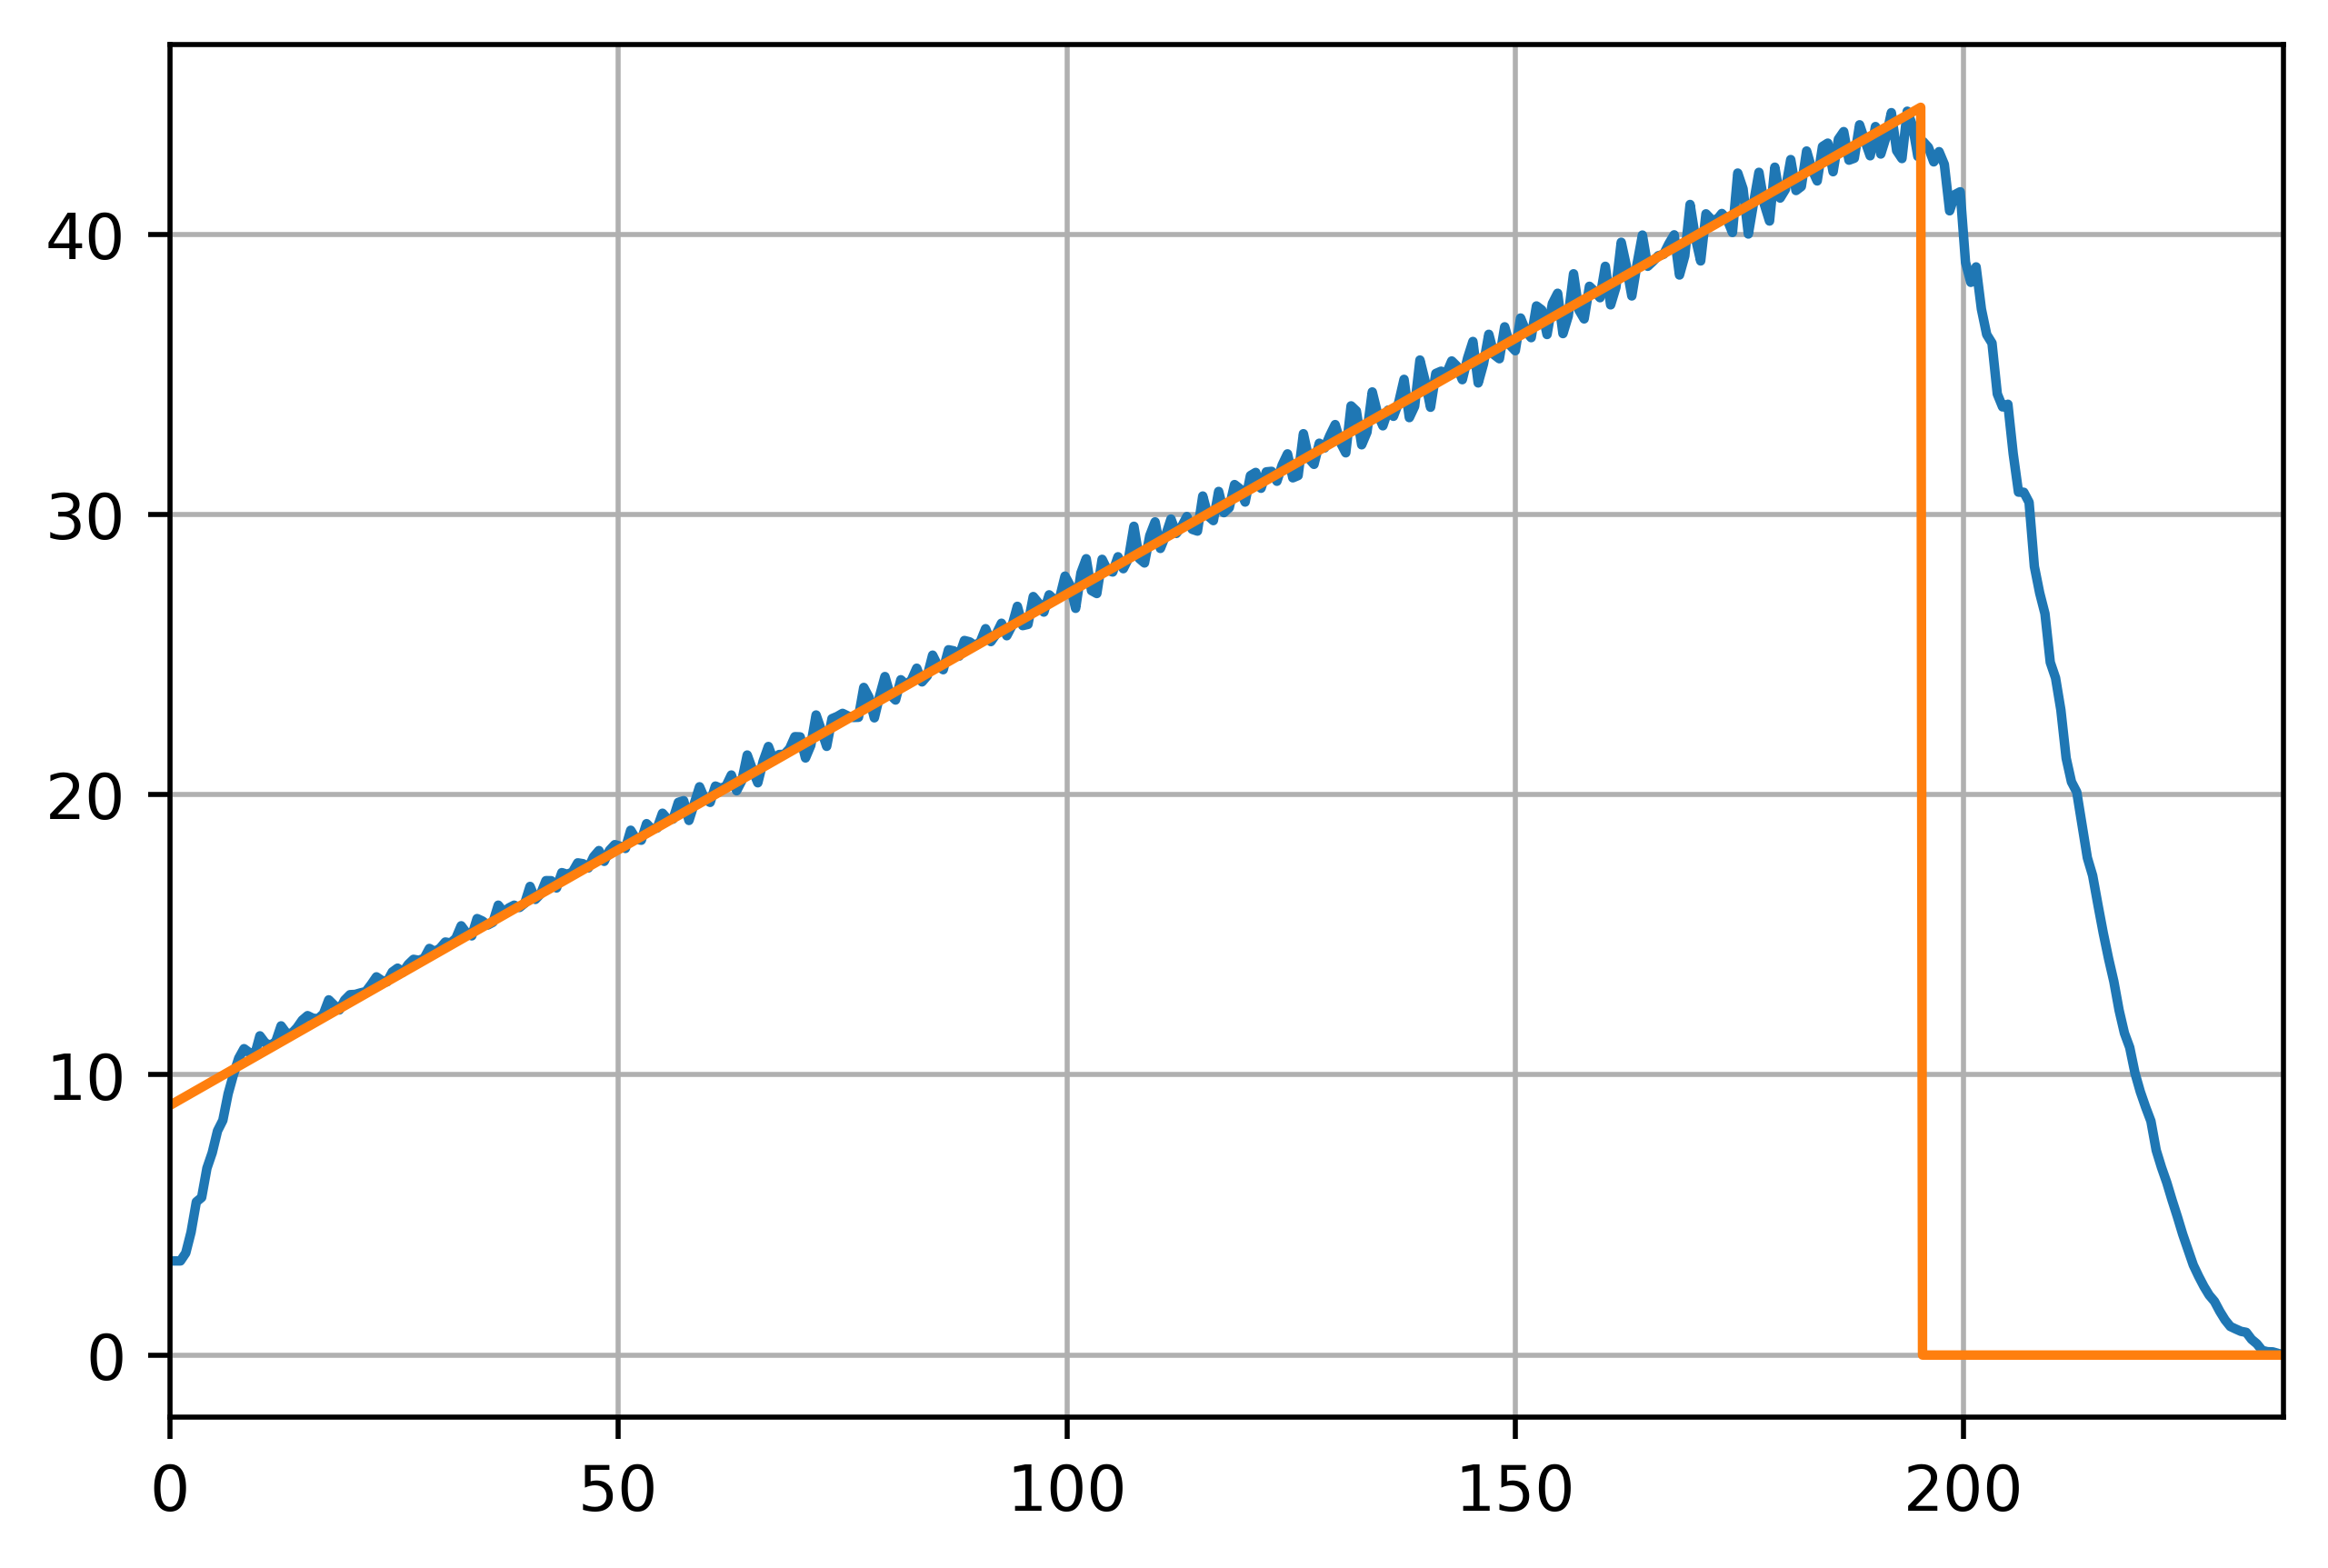

FE Start
FE Complete


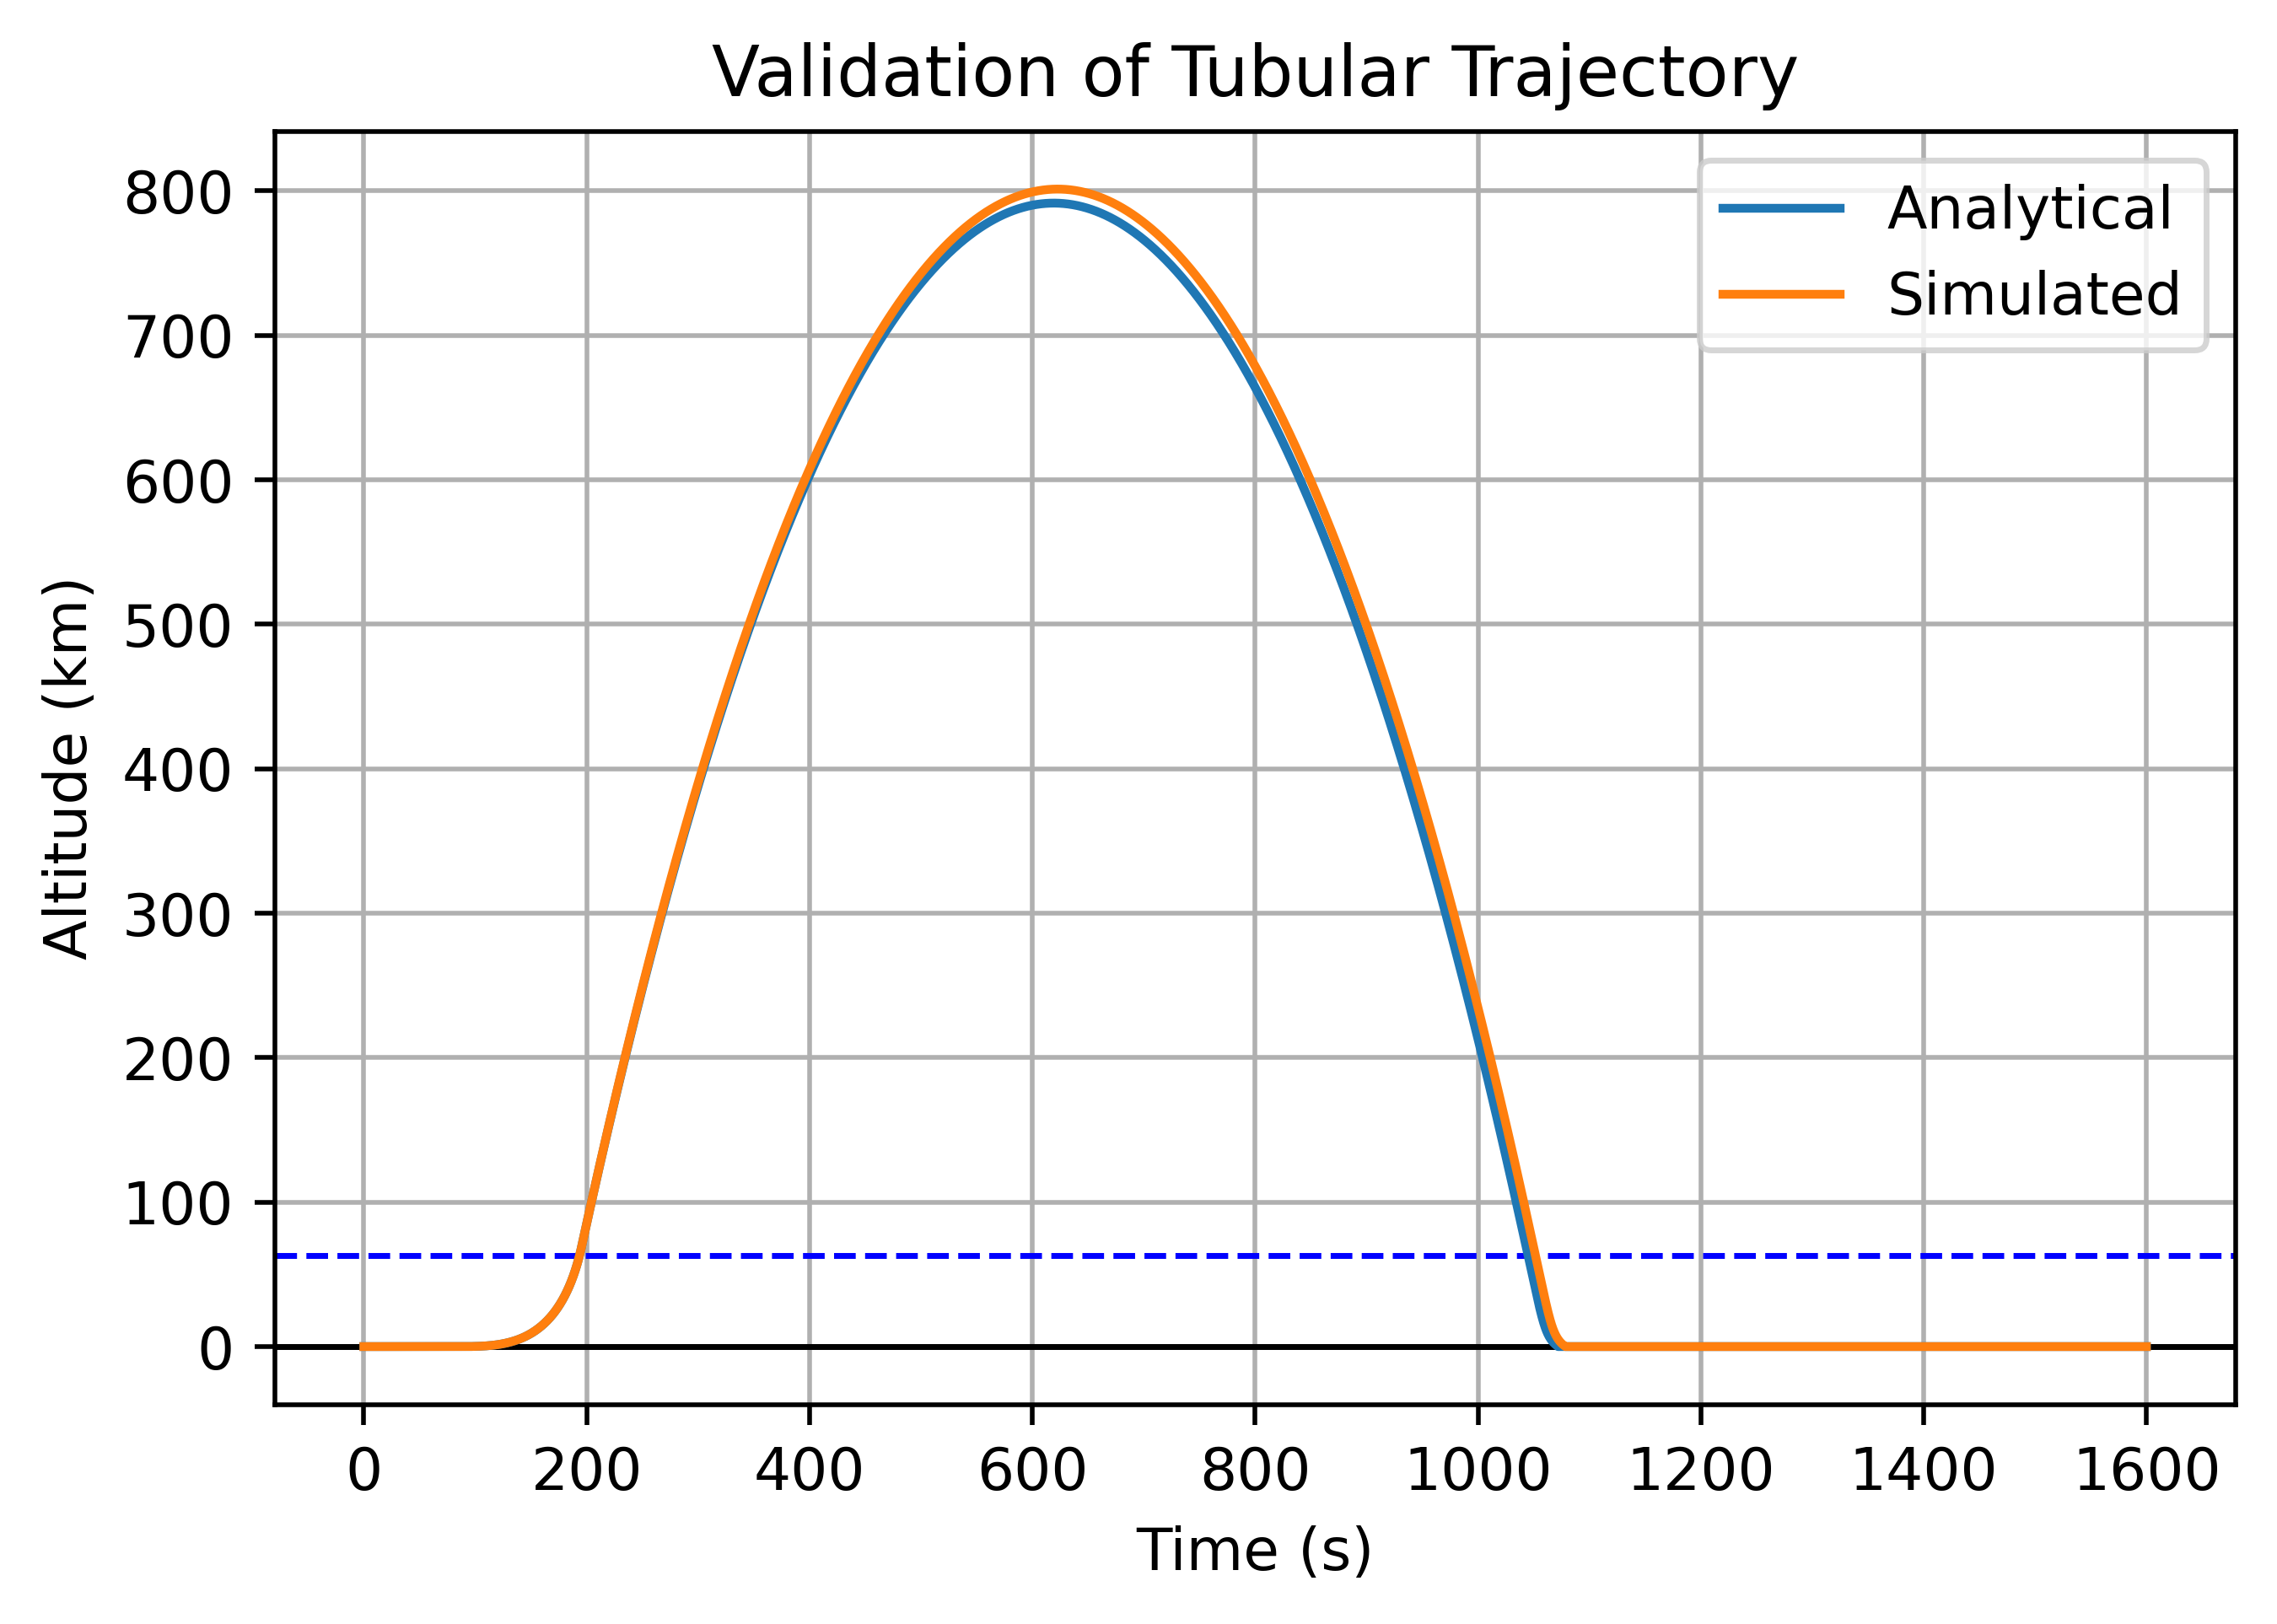

In [17]:
tubularAreas = []
for t_it in times:
    tubularAreas.append(tubular(starting_r, rate, D/2, t_it))

scaledSurface = interp1d(surface/surfaceScale, new_len=400)
scaledTimes = interp1d(Simtimes/timeScale, new_len=400)
#plt.plot(scaledTimes, scaledSurface)

plt.plot(scaledTimes, scaledSurface)


# ANALYTICAL TRAJECTORY    

Areas1 = [times, tubularAreas]
data1 = forward(model, times, IV, Areas1)
plt.plot(times, tubularAreas)
plt.xlim(0, max(scaledTimes))
plt.show()

# SIMULATED TRAJECTORY

Areas2 = [scaledTimes, scaledSurface]
data_A1_SIM = forward(model, times, IV, Areas2, sim=True)

datas = [data1, data_A1_SIM]
labels = ["Analytical", "Simulated"]

plotter(datas, times, labels, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
        hlines=[P001PointRho/1000, 0], vlines=[], tmn = 0, tmx = int(tmax/inc), Title="Validation of Tubular Trajectory")

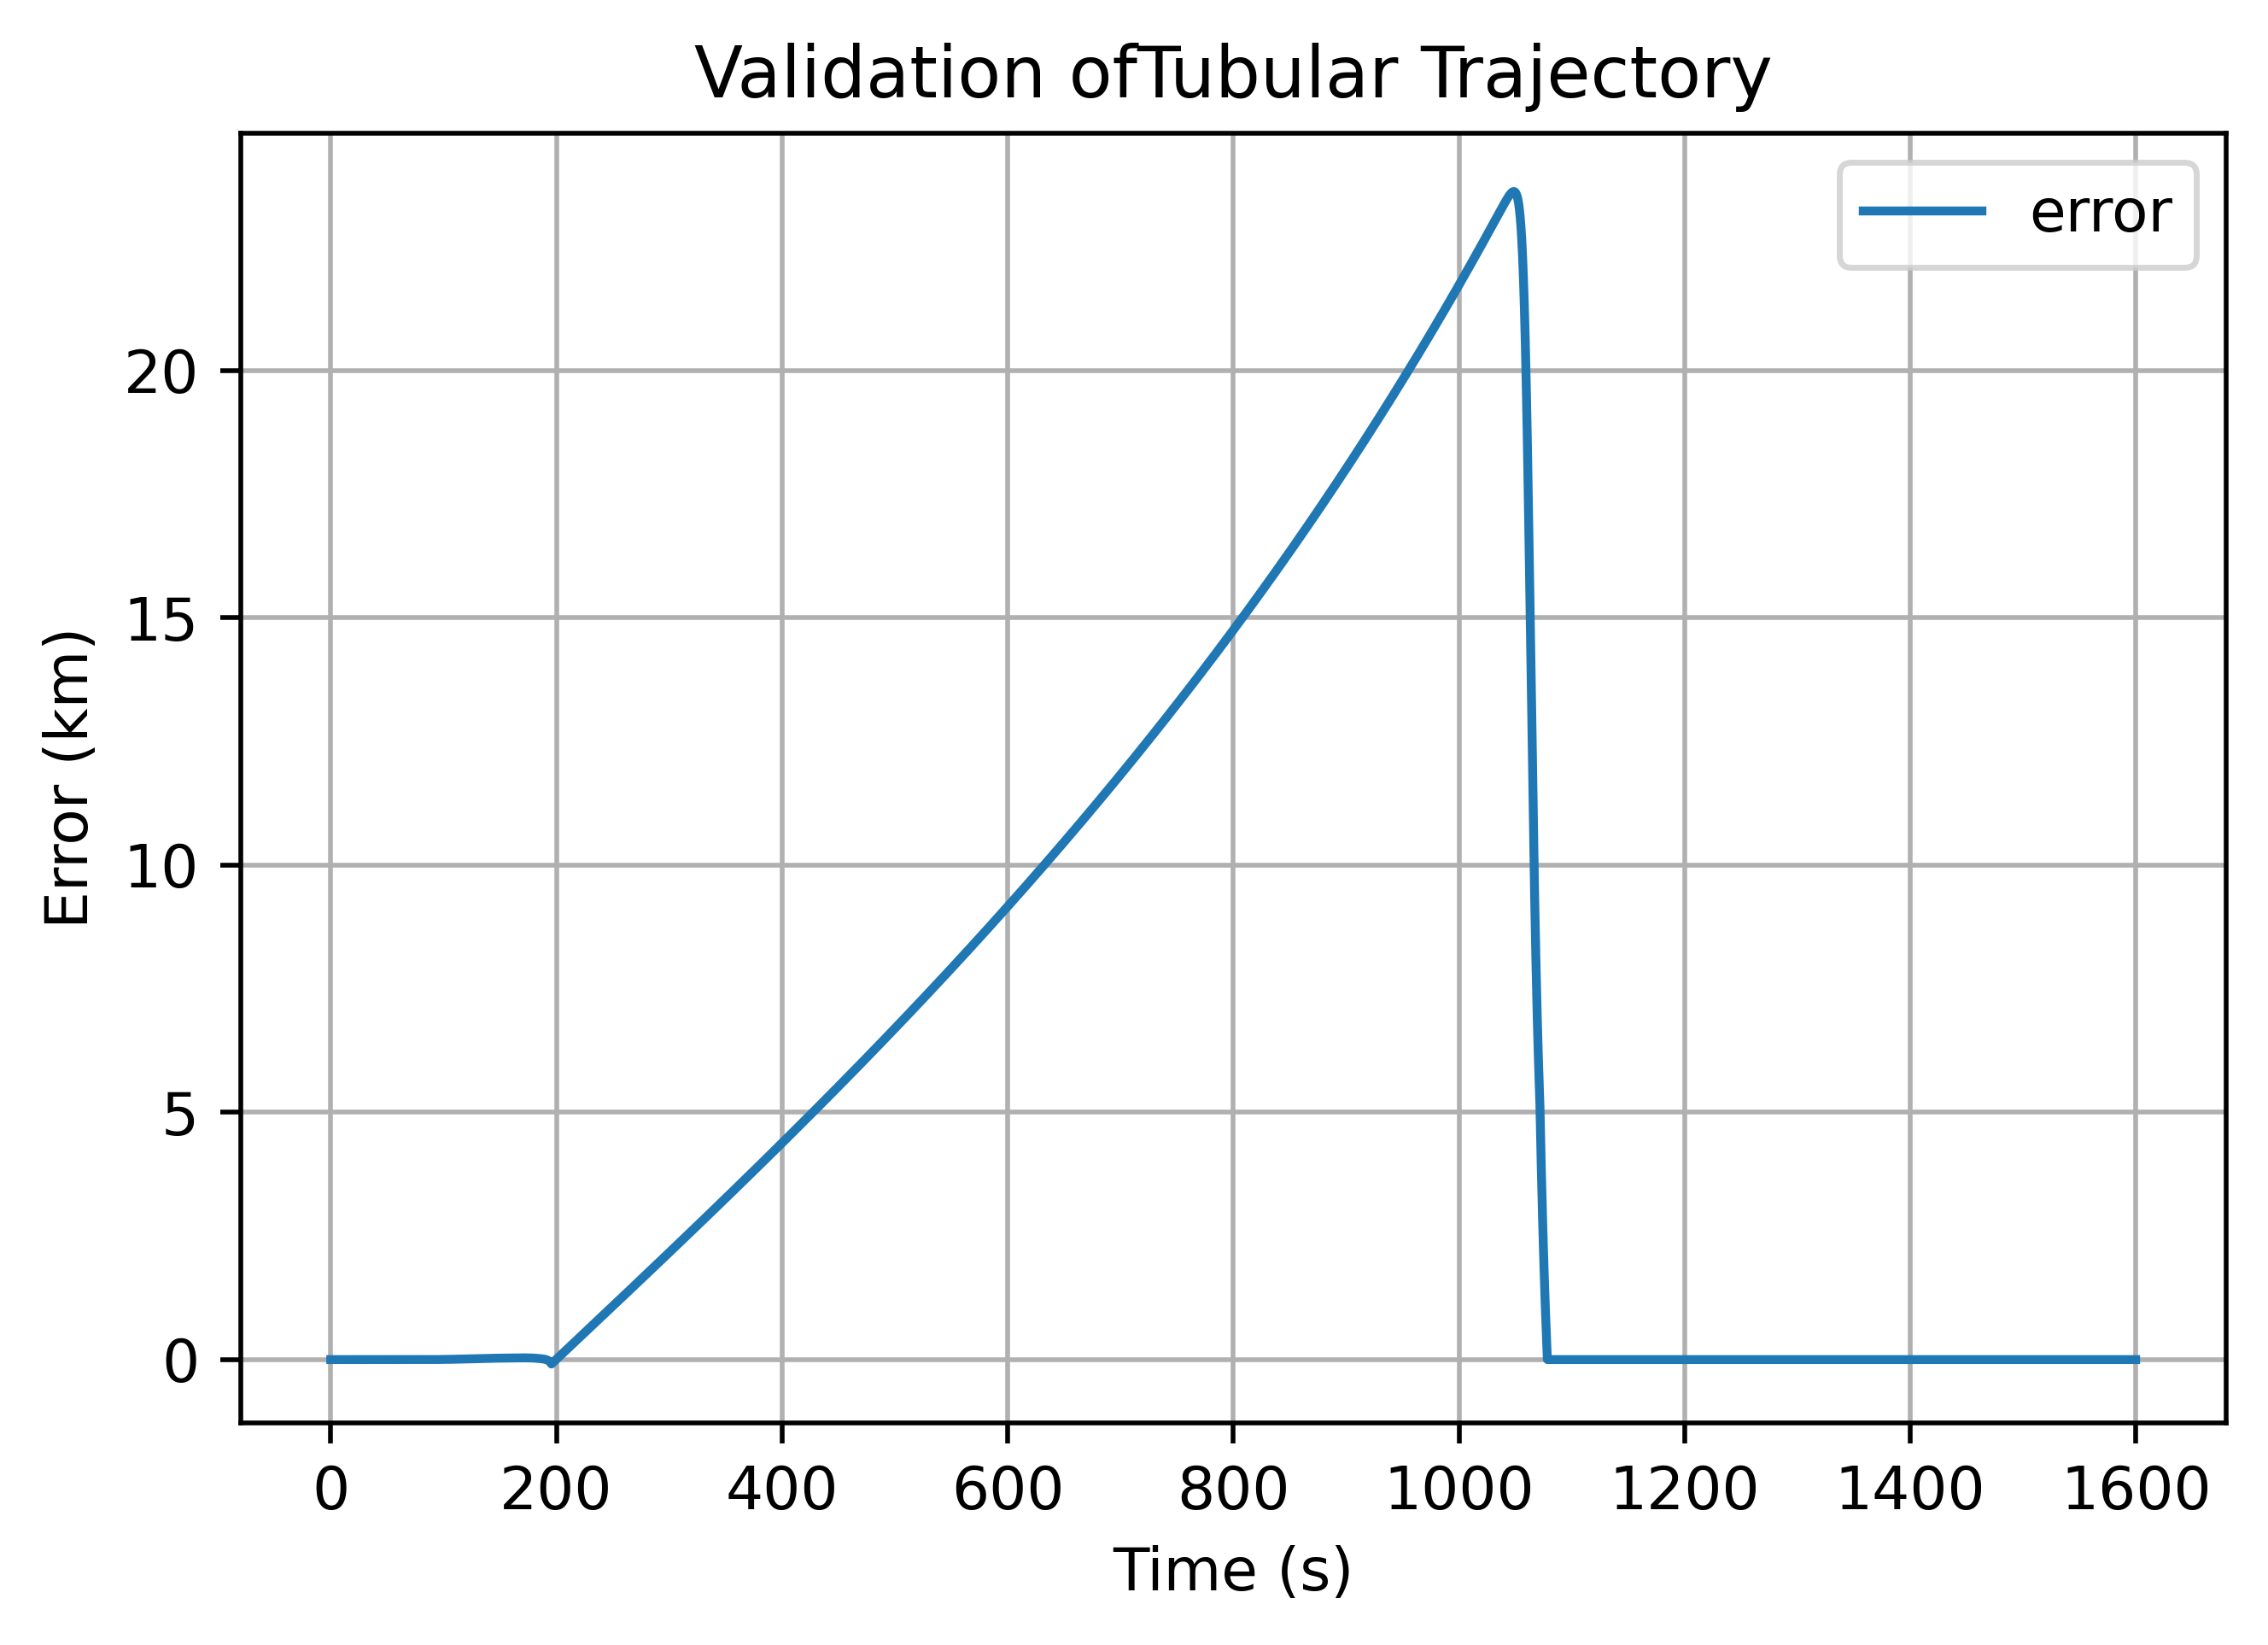

In [18]:
real = datas[0]
sim = datas[1]

datase = [sim - real]
labels = ["error"]

plotter(datase, times, labels, index=0, xlab="Time (s)", ylab="Error (km)", legend=True, vlines=[], tmn = 0, tmx = int(tmax/inc), Title="Validation ofTubular Trajectory")


In [19]:
np.savetxt('Tubular_Analytical.csv', (times, data1[:, 0], data_A1_SIM[:, 0]), delimiter=',')

### Simulation 2: Validating Trajectories for Rod and Tube Design

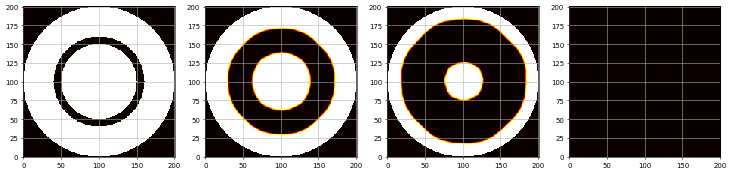

In [20]:
burns = []
a = getA2()
snapshots, burns, n_trials = burnAnalysis(a, rate_pixel)
surface = burns_to_areas(burns)
Simtimes = np.arange(0, n_trials, 1)

Simtimes = np.array(Simtimes)
surface = np.array(surface)

plotCourse(snapshots, n_trials)

In [21]:
areaTimes = np.arange(0, 250, .1)
rod_tube_Areas = []
for time in areaTimes:
    rod_tube_Areas.append(rod_and_tube(D/10, rate, D/2, time))

Text(0.5, 0, 'Time (s)')

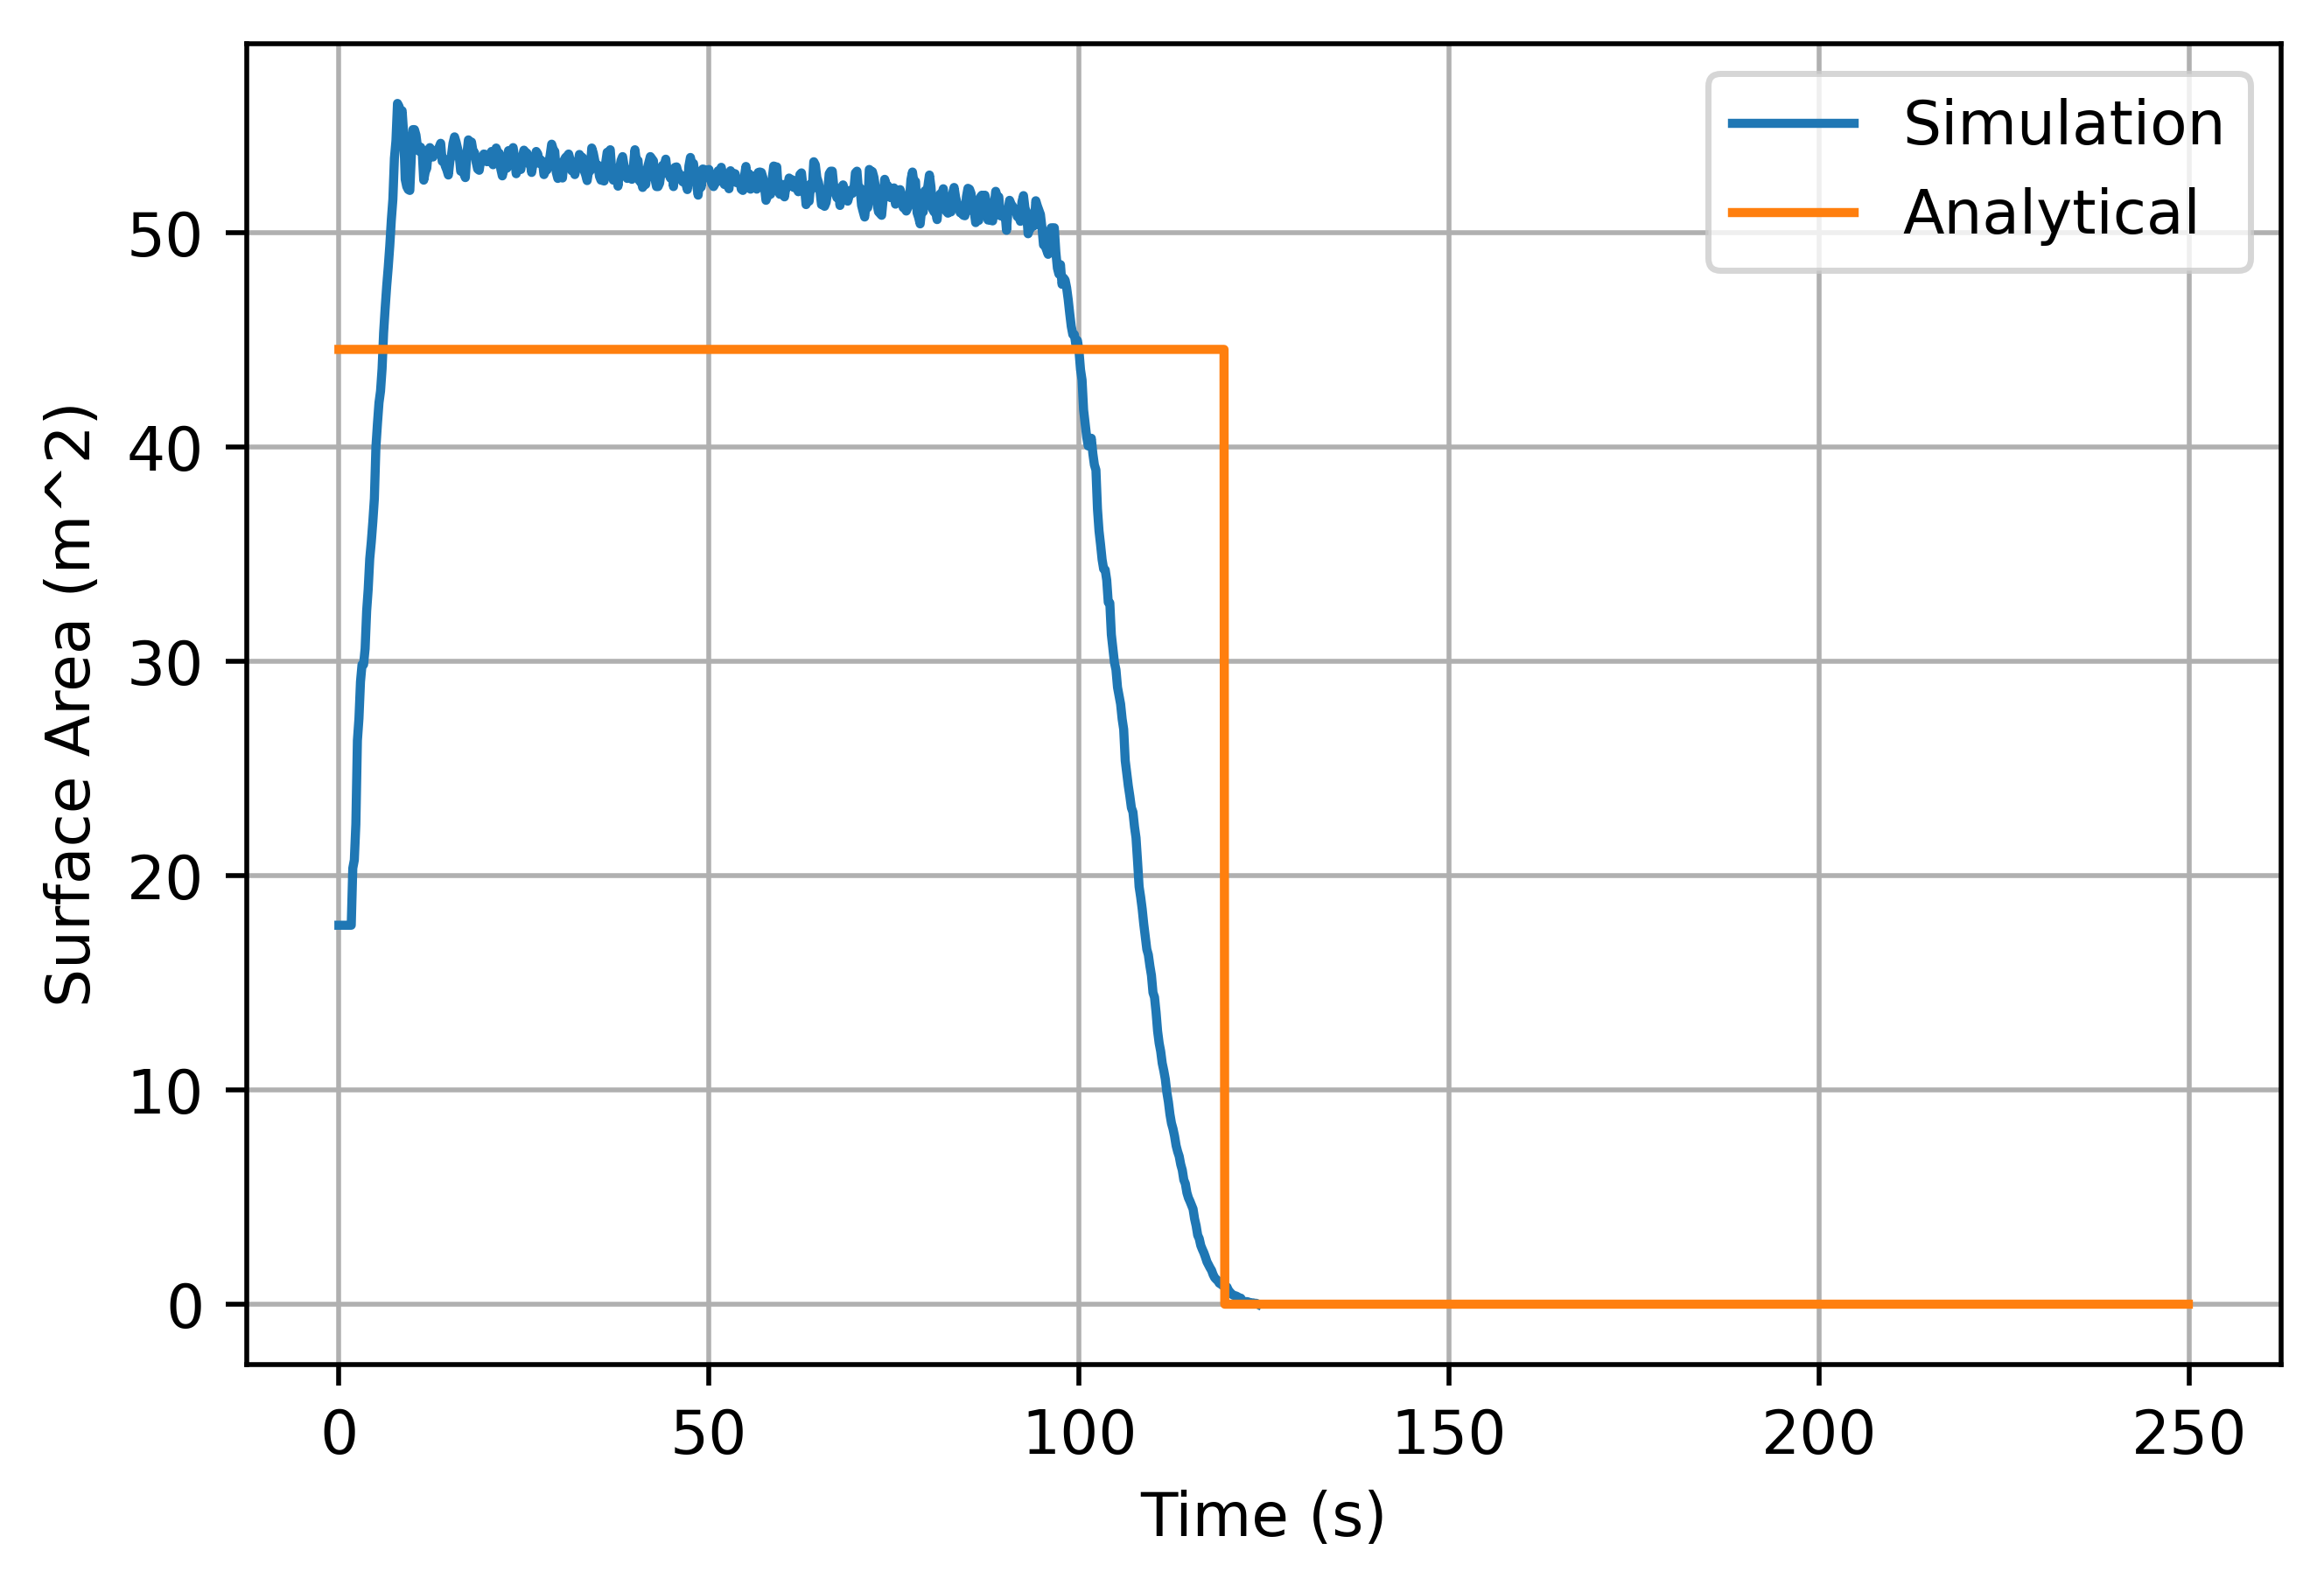

In [22]:
plt.plot(Simtimes/timeScale, surface/surfaceScale, label = "Simulation")
plt.plot(areaTimes, rod_tube_Areas, label = "Analytical")
plt.legend()
plt.ylabel("Surface Area (m^2)")
plt.xlabel("Time (s)")

FE Start
FE Complete
FE Start
FE Complete


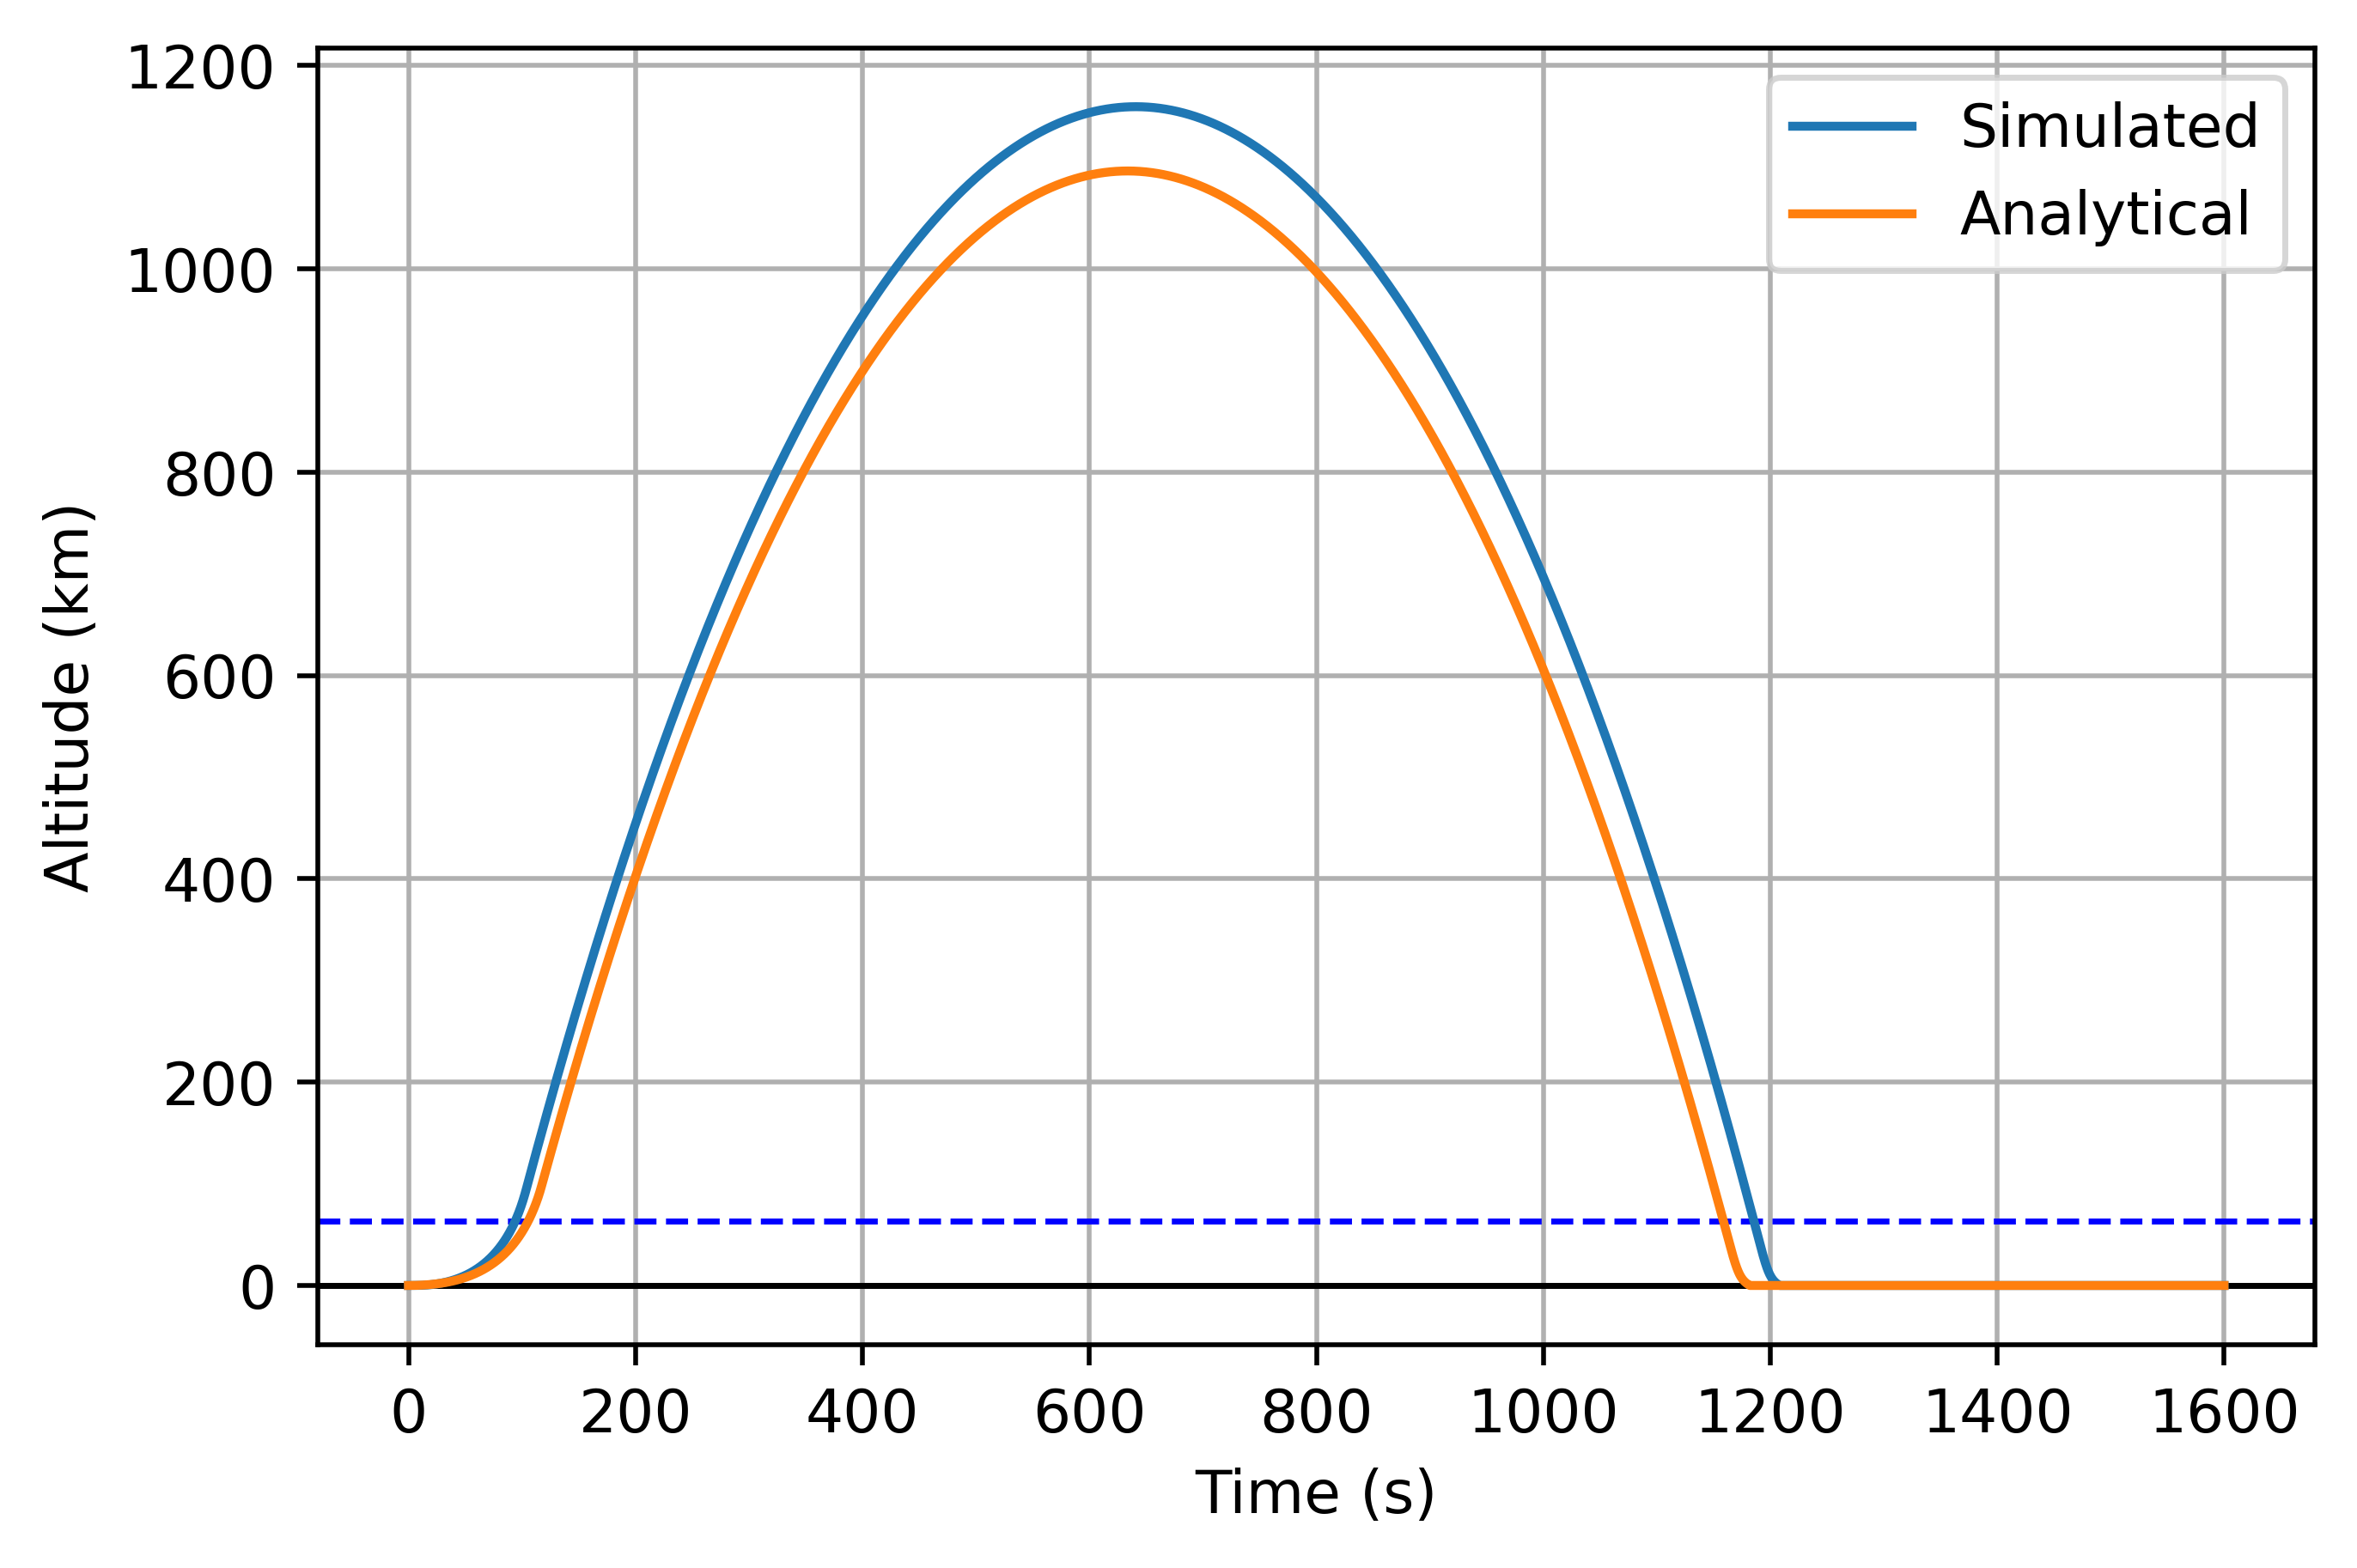

In [23]:
rod_tube_Areas = []
for t_it in times:
    rod_tube_Areas.append(rod_and_tube(starting_r, rate, D/2, t_it))

scaledSurface = interp1d(surface/surfaceScale, new_len=400)
scaledTimes = interp1d(Simtimes/timeScale, new_len=400)
#plt.plot(scaledTimes, scaledSurface)

# ANALYTICAL TRAJECTORY    

Areas1 = [times, rod_tube_Areas]
data1 = forward(model, times, IV, Areas1)

# SIMULATED TRAJECTORY

Areas2 = [scaledTimes, scaledSurface]
data_A2_SIM = forward(model, times, IV, Areas2, sim=True)

datas = [data_A2_SIM, data1]
labels = ["Simulated", "Analytical"]

plotter(datas, times, labels, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
        hlines=[P001PointRho/1000, 0], vlines=[], tmn = 0, tmx = int(tmax/inc), Title="")

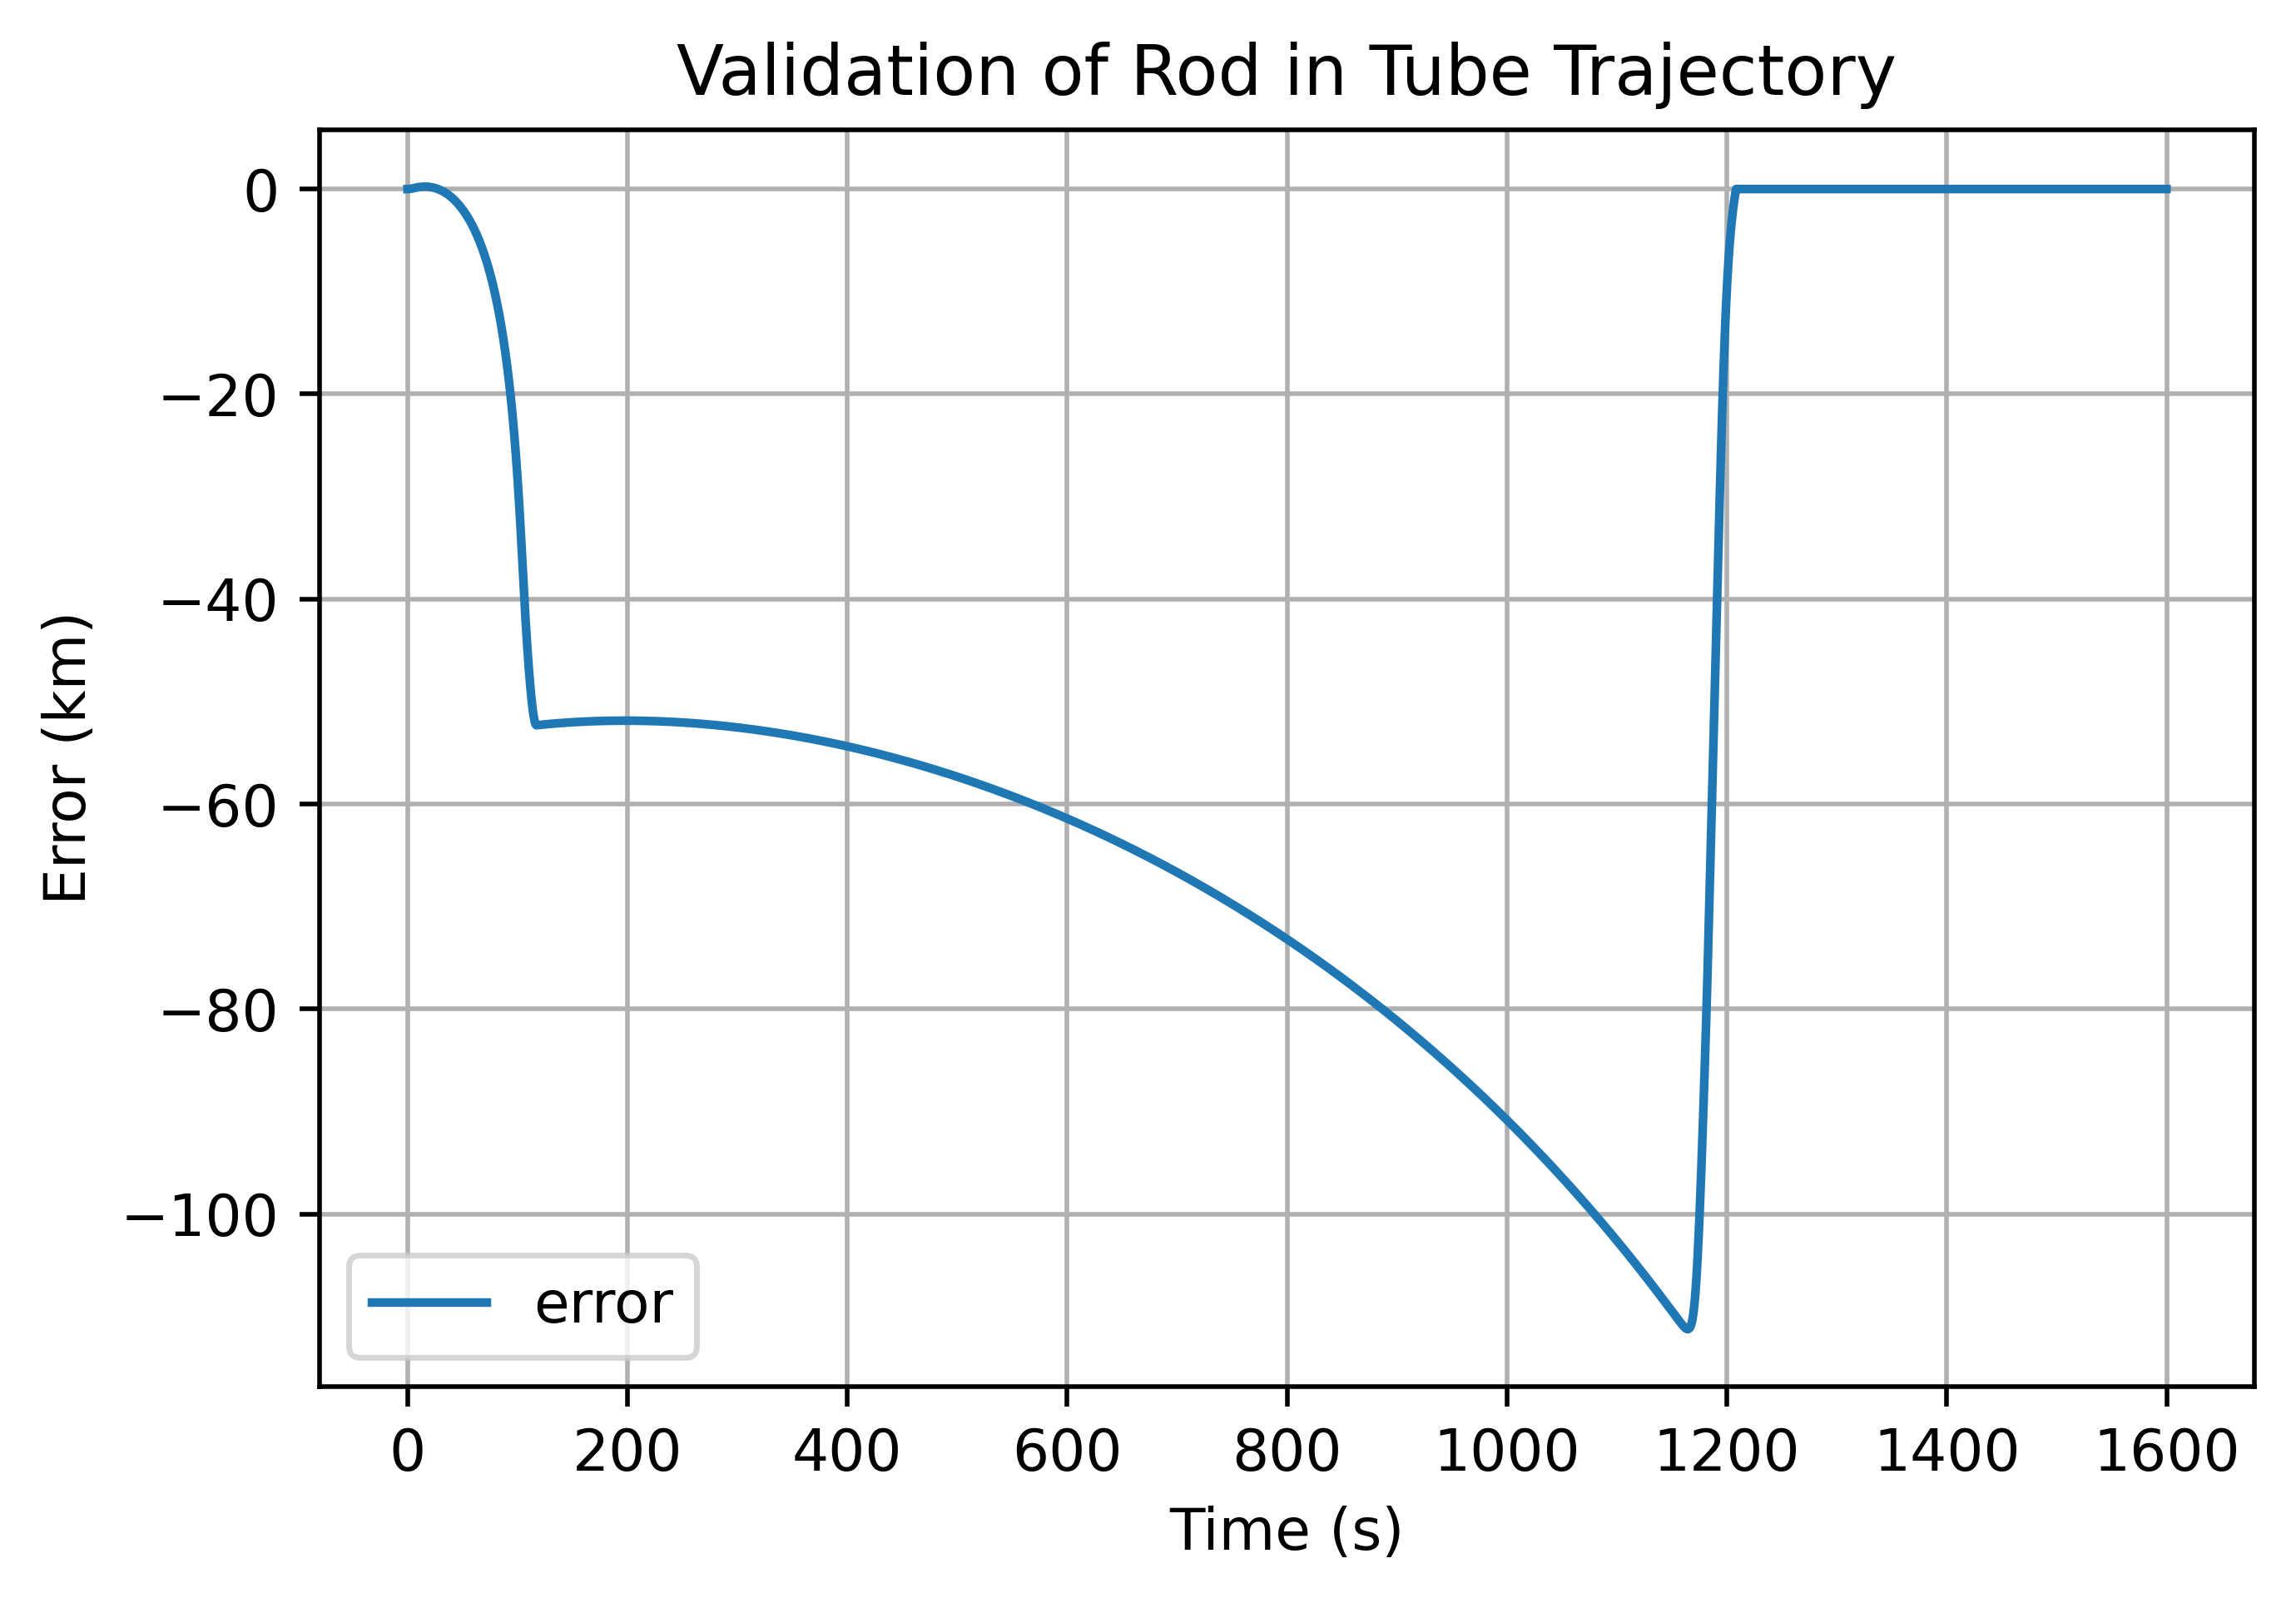

In [24]:
real = datas[0]
sim = datas[1]

datase = [sim - real]
labels = ["error"]

plotter(datase, times, labels, index=0, xlab="Time (s)", ylab="Error (km)", legend=True, vlines=[], tmn = 0, tmx = int(tmax/inc), Title="Validation of Rod in Tube Trajectory")


In [25]:
np.savetxt('Rod-Tube Data.csv', (times, data1[:, 0], data_A2_SIM[:, 0]), delimiter=',')

### Simulation 3: Validating Trajectories for Cross Design


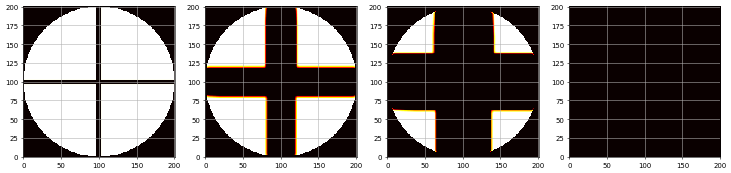

In [26]:
a = getA3()
snapshots, burns3, n_trials = burnAnalysis(a, rate_pixel)
surface = burns_to_areas(burns3)
Simtimes = np.arange(0, n_trials, 1)

Simtimes = np.array(Simtimes)
surface = np.array(surface)

plotCourse(snapshots, n_trials)

# VALIDATION OF CROSS MODEL & TESTING OF SIMULATION REDUCTION

Here, N represents the length of the array of simulation values. An interpolation function is used to squeeze the simulation values into an array of my choice, testing whether or not we can eliminate noise while conforming roughly to the analytical solution

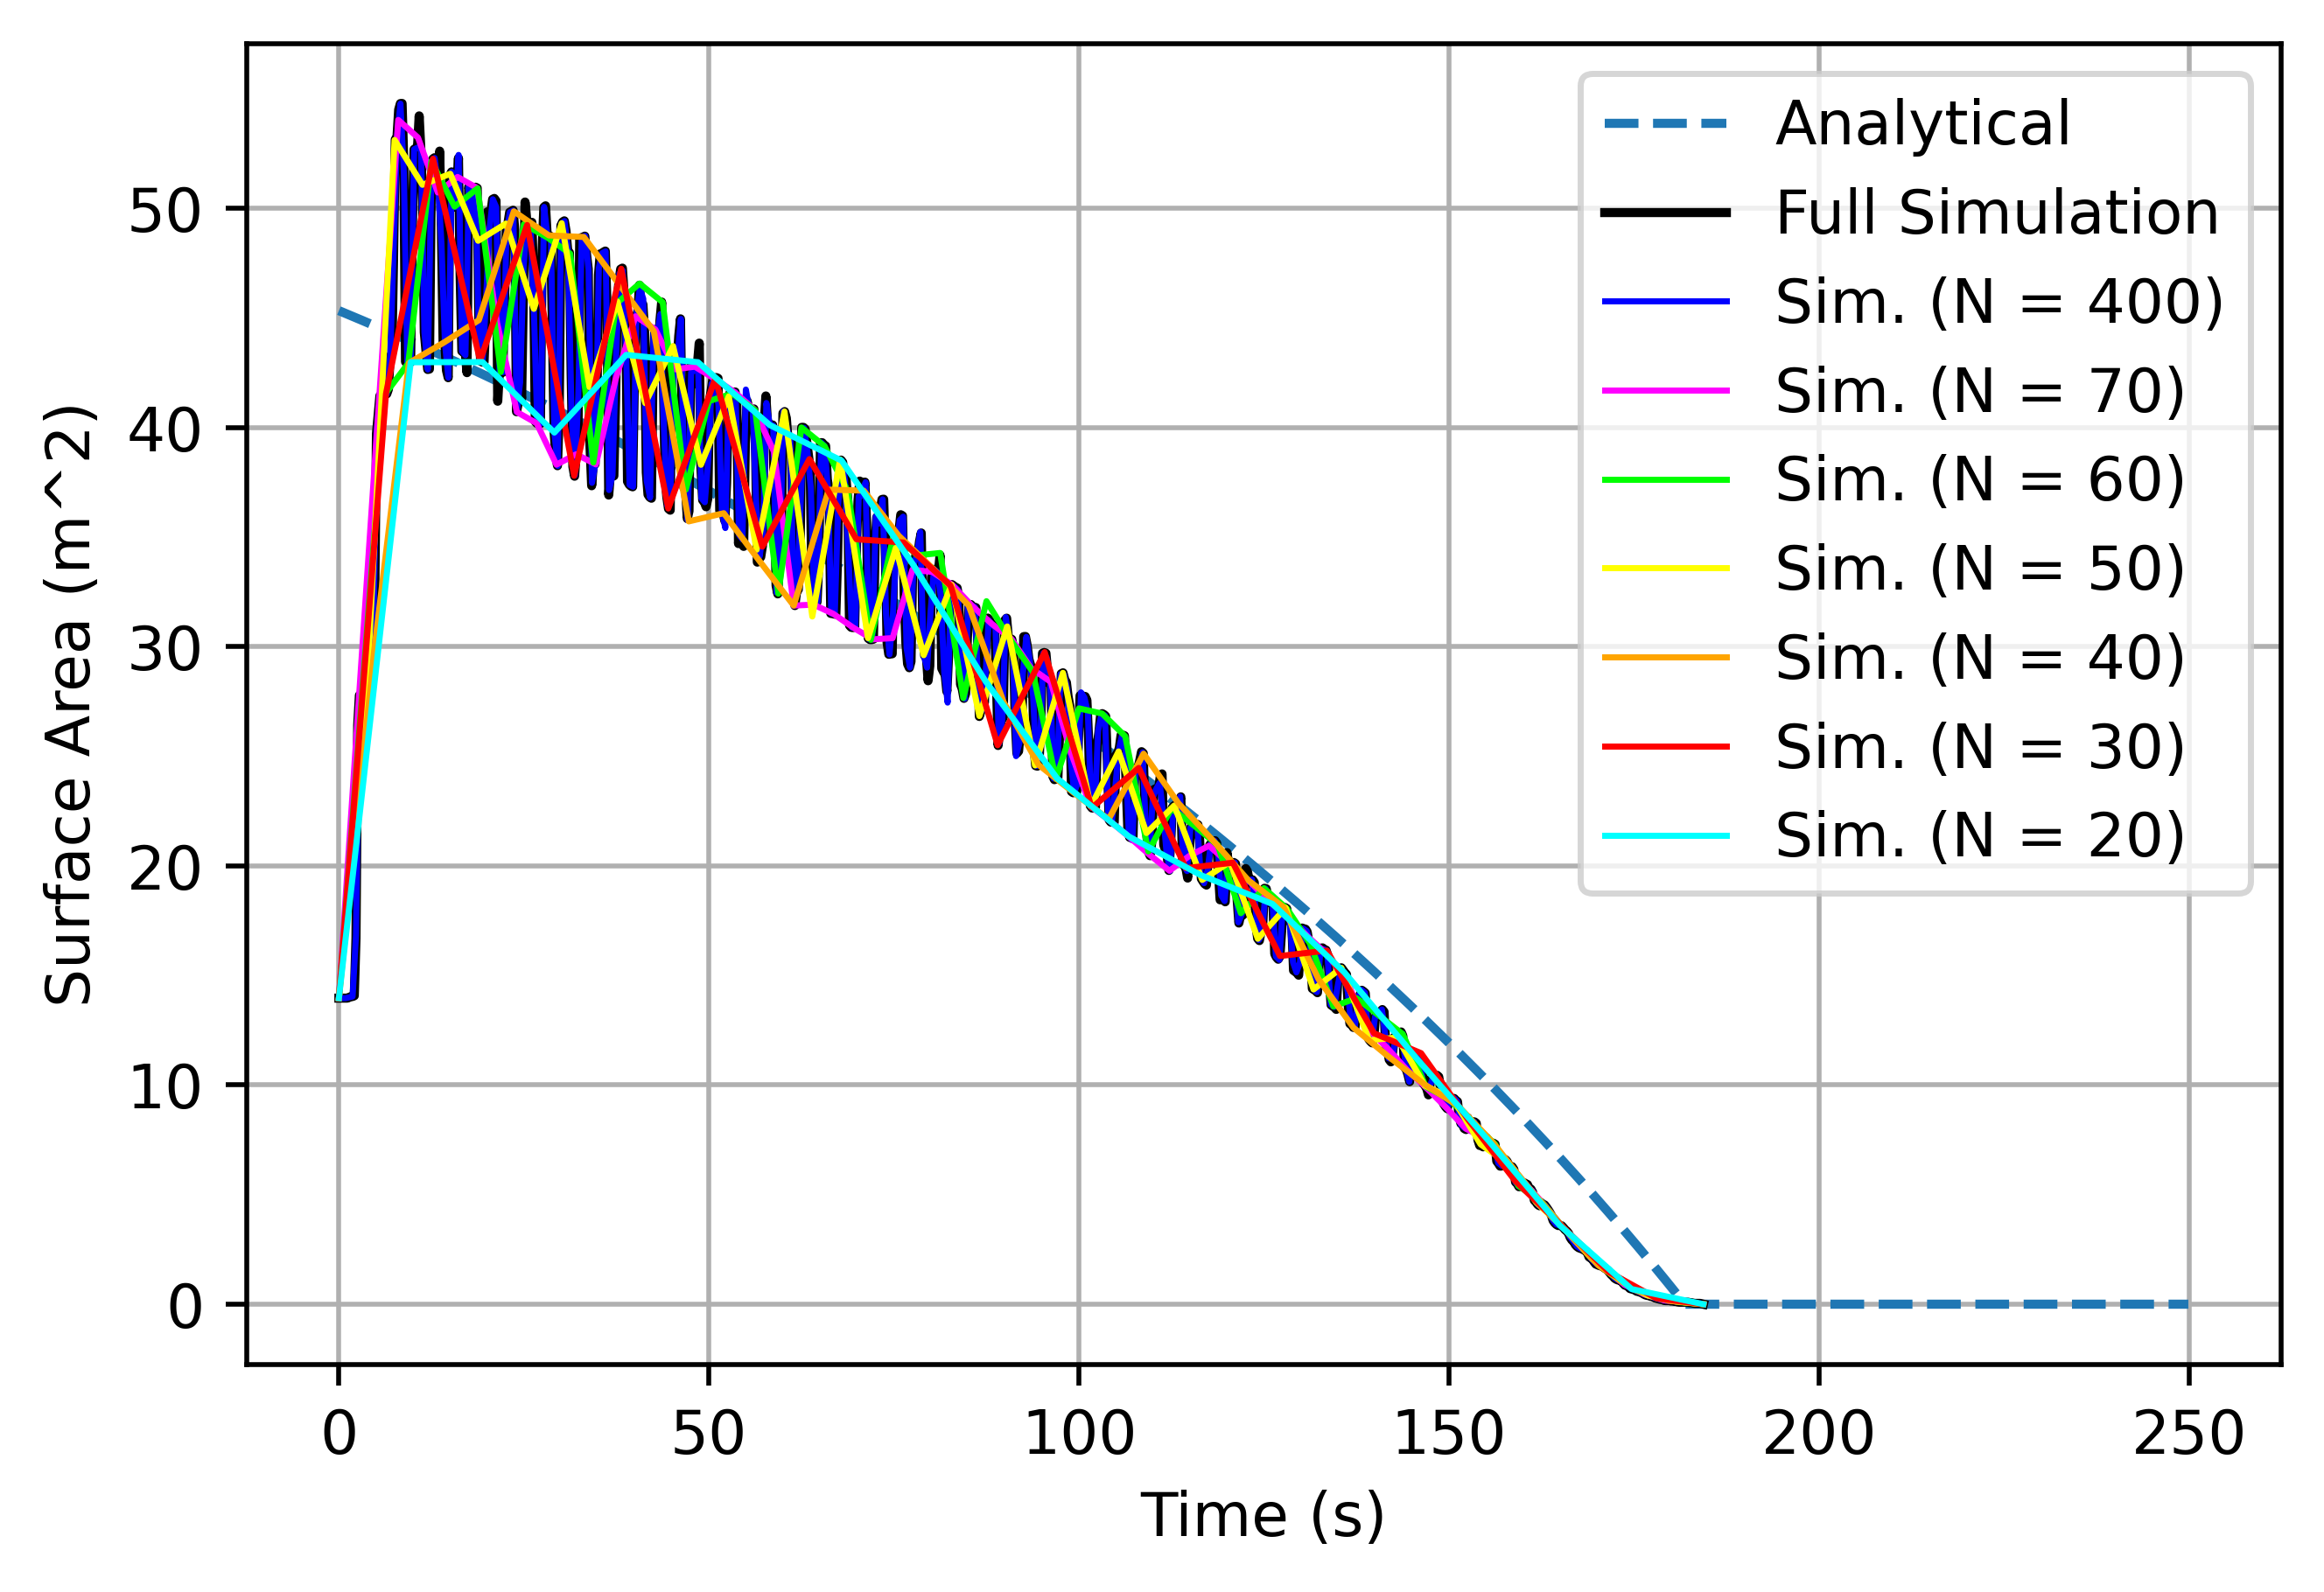

FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete
FE Start
FE Complete


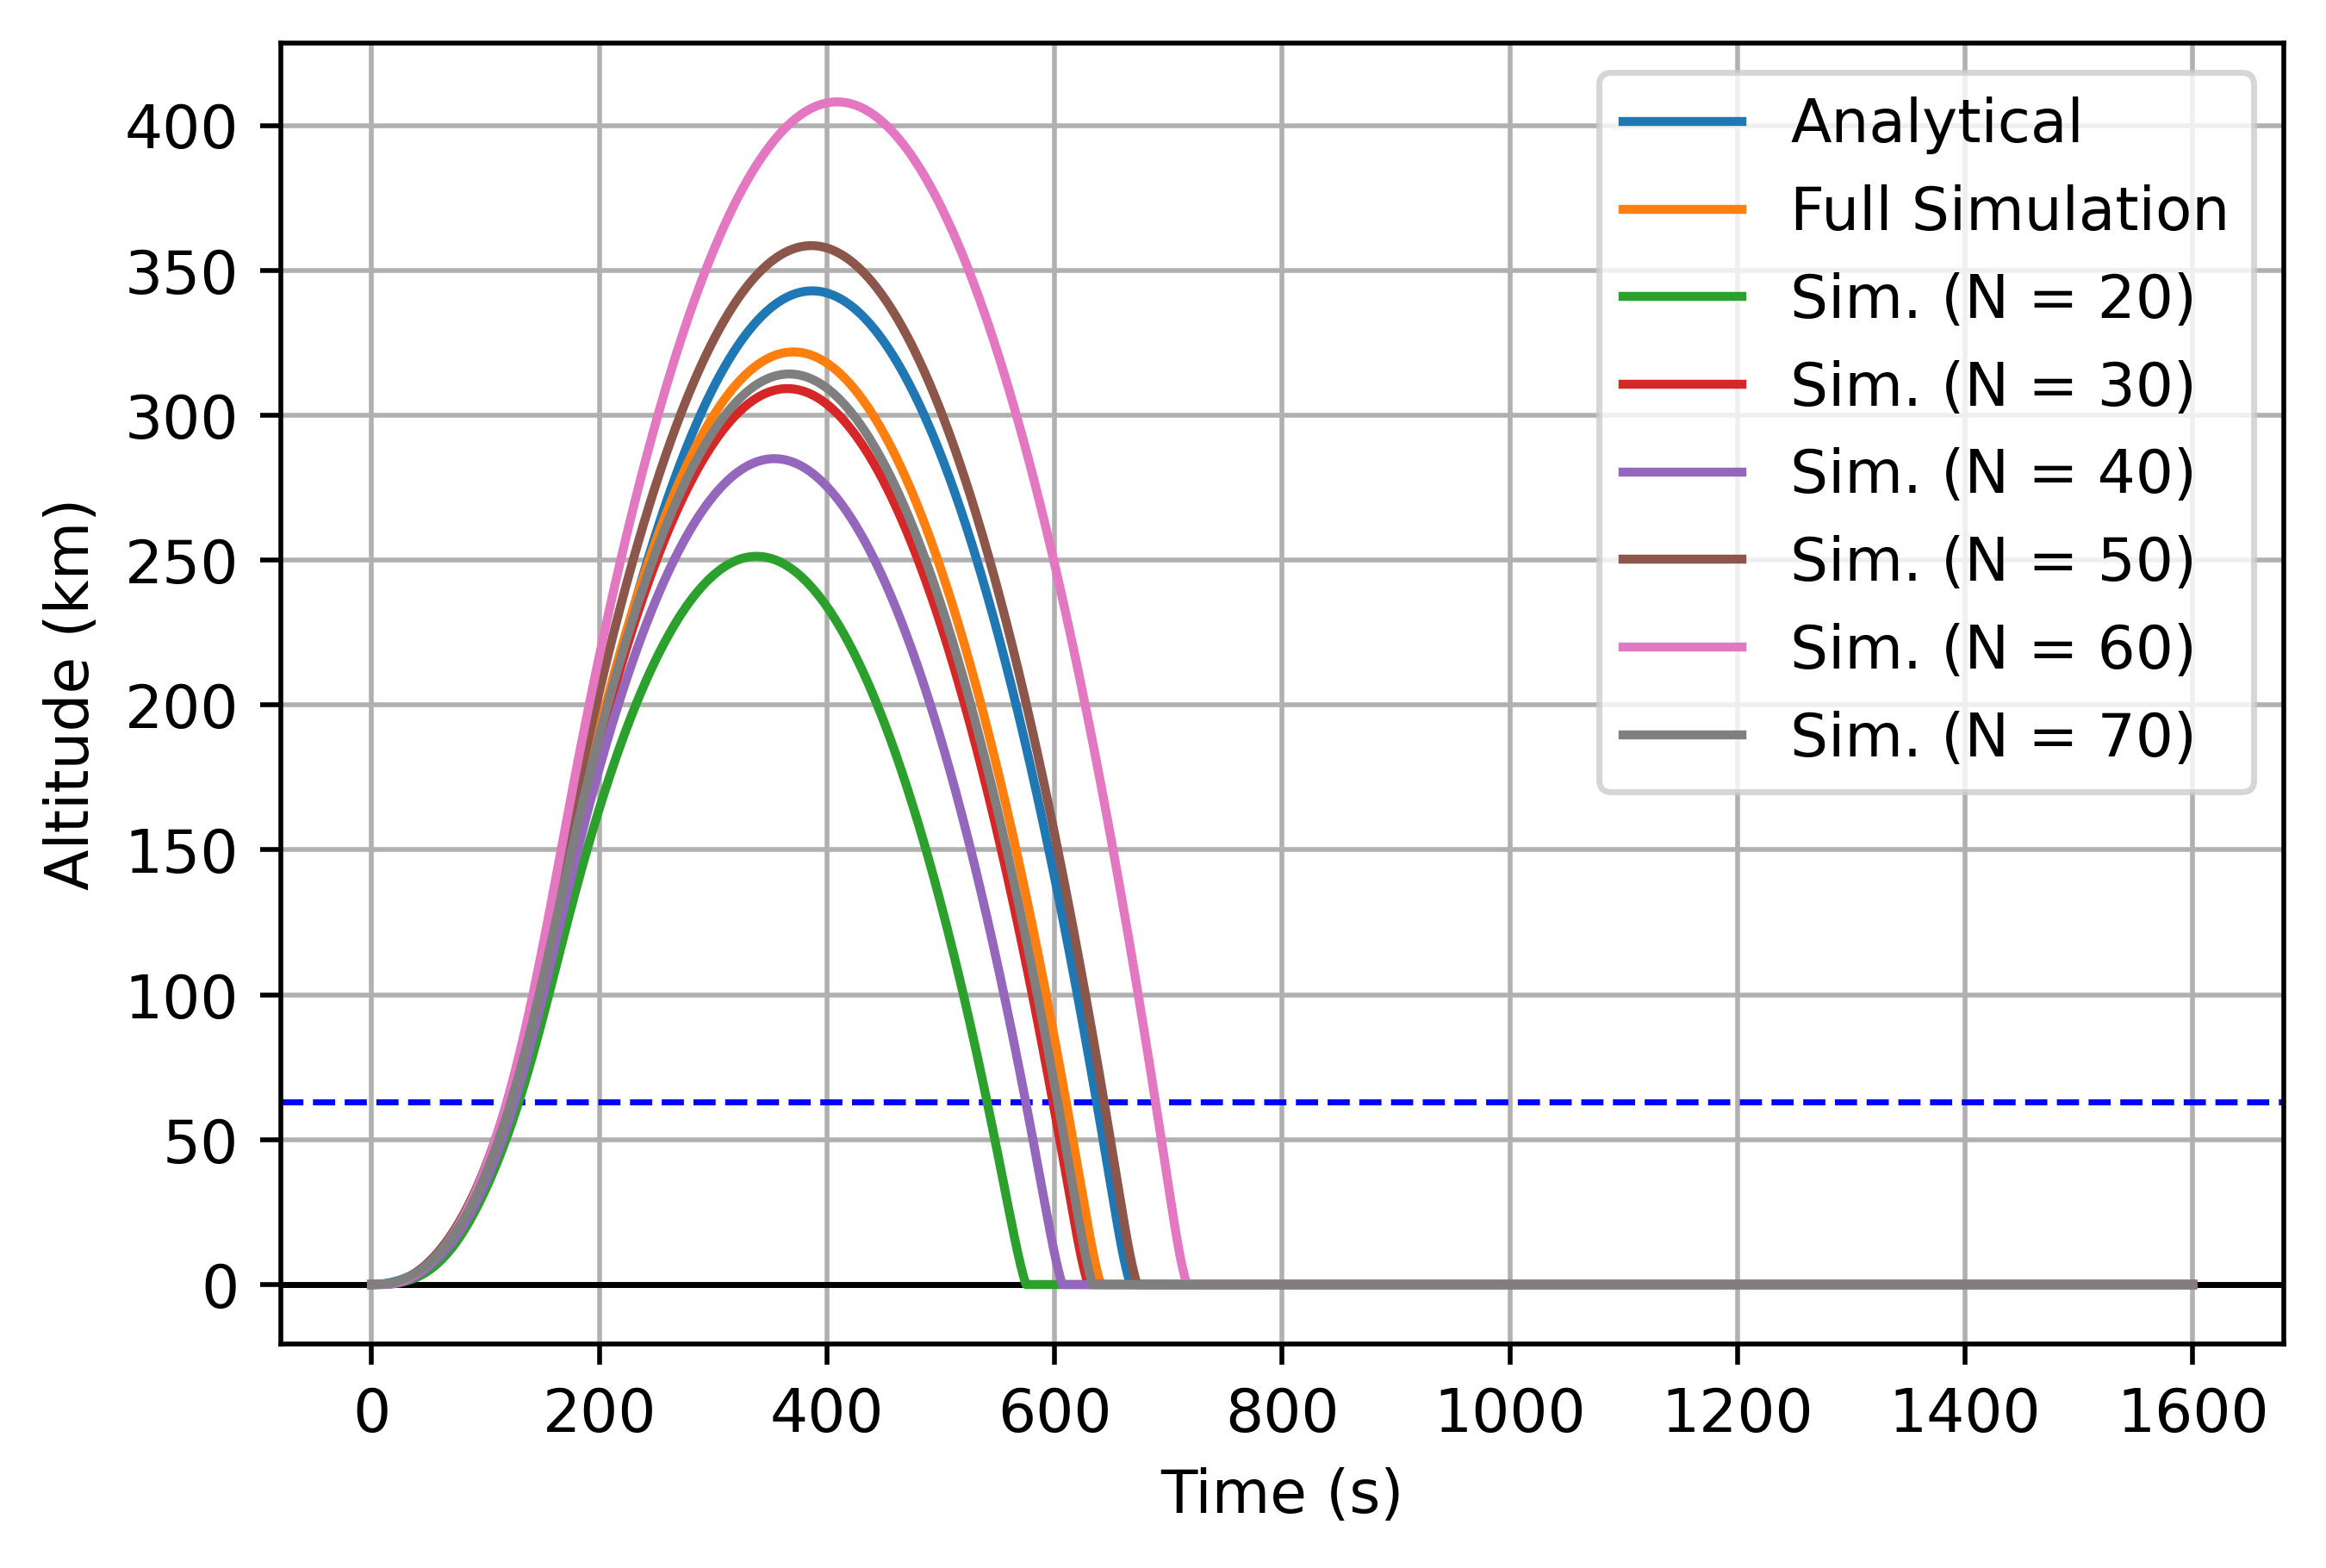

In [39]:
areaTimes = np.arange(0, 250, .1)

# Get analytical solution for evaluation

cross_Areas = []
for time in areaTimes:
    cross_Areas.append(cross(D/10, rate, D/2, time, bevel=True))
length = 800
scaledSurface = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(areaTimes, cross_Areas, label = "Analytical", linestyle='dashed')  
plt.plot(scaledTimes, scaledSurface, label = "Full Simulation", color='k')


plt.ylabel("Surface Area (m^2)")
plt.xlabel("Time (s)")

length = 400
scaledSurface400 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes400 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes400, scaledSurface400, label = "Sim. (N = "+str(length)+")", linewidth=1, color='blue')

length = 70
scaledSurface70 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes70 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes70, scaledSurface70, label = "Sim. (N = "+str(length)+")", linewidth=1, color='magenta')

length = 60
scaledSurface60 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes60 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes60, scaledSurface60, label = "Sim. (N = "+str(length)+")", linewidth=1, color='lime')


length = 50
scaledSurface50 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes50 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes50, scaledSurface50, label = "Sim. (N = "+str(length)+")", linewidth=1, color='yellow')



length = 40
scaledSurface40 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes40 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes40, scaledSurface40, label = "Sim. (N = "+str(length)+")", linewidth=1, color='orange')

length = 30
scaledSurface30 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes30 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes30, scaledSurface30, label = "Sim. (N = "+str(length)+")", linewidth=1, color='red')


length = 20
scaledSurface20 = interp1d(surface/surfaceScale/1.1, new_len=length)
scaledTimes20 = interp1d(Simtimes/timeScale, new_len=length)    
plt.plot(scaledTimes20, scaledSurface20, label = "Sim. (N = "+str(length)+")", linewidth=1, color='cyan')
plt.legend()
plt.show()

# Get analytical solution fit to x axis

cross_Areas = []
for t_it in times:
    cross_Areas.append(cross(starting_r, rate, D/2, t_it, bevel=True))
    #cross_Areas.append(cross(starting_r, rate, D/2, t_it, bevel=False))

#plt.plot(scaledTimes, scaledSurface)

# ANALYTICAL TRAJECTORY    

Areas1 = [times, cross_Areas]
data1 = forward(model, times, IV, Areas1)

# SIMULATED TRAJECTORY

Areas2 = [scaledTimes, scaledSurface]
data_A3_SIM = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes400, scaledSurface400]
data_A3_SIM400 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes50, scaledSurface50]
data_A3_SIM50 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes20, scaledSurface20]
data_A3_SIM20 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes30, scaledSurface30]
data_A3_SIM30 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes40, scaledSurface40]
data_A3_SIM40 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes60, scaledSurface60]
data_A3_SIM60 = forward(model, times, IV, Areas2, sim=True)

Areas2 = [scaledTimes70, scaledSurface70]
data_A3_SIM70 = forward(model, times, IV, Areas2, sim=True)

datas = [data1, data_A3_SIM, data_A3_SIM20, data_A3_SIM30, data_A3_SIM40, data_A3_SIM50, data_A3_SIM60, data_A3_SIM70]
labels = ["Analytical", "Full Simulation", "Sim. (N = 20)", "Sim. (N = 30)", "Sim. (N = 40)", "Sim. (N = 50)",  "Sim. (N = 60)", "Sim. (N = 70)",]

plotter(datas, times, labels, index=0, xlab="Time (s)", ylab="Altitude (km)", legend=True, 
        hlines=[P001PointRho/1000, 0], vlines=[], tmn = 0, tmx = int(tmax/inc))

In [35]:
np.savetxt('Cross Data.csv', (times, data1[:, 0], data_A3_SIM[:, 0]), delimiter=',')

<ipython-input-37-099f776873ce>:21: RuntimeWarning: invalid value encountered in true_divide
  datase = [(sim800 - real)/real]
<ipython-input-37-099f776873ce>:22: RuntimeWarning: invalid value encountered in true_divide
  datase2 = [(sim20 - real)/real]
<ipython-input-37-099f776873ce>:23: RuntimeWarning: invalid value encountered in true_divide
  datase3 = [(sim30 - real)/real]
<ipython-input-37-099f776873ce>:24: RuntimeWarning: invalid value encountered in true_divide
  datase4 = [(sim40 - real)/real]
<ipython-input-37-099f776873ce>:25: RuntimeWarning: divide by zero encountered in true_divide
  datase5 = [(sim50 - real)/real]
<ipython-input-37-099f776873ce>:25: RuntimeWarning: invalid value encountered in true_divide
  datase5 = [(sim50 - real)/real]
<ipython-input-37-099f776873ce>:26: RuntimeWarning: divide by zero encountered in true_divide
  datase6 = [(sim60 - real)/real]
<ipython-input-37-099f776873ce>:26: RuntimeWarning: invalid value encountered in true_divide
  datase6 = [(si

Done


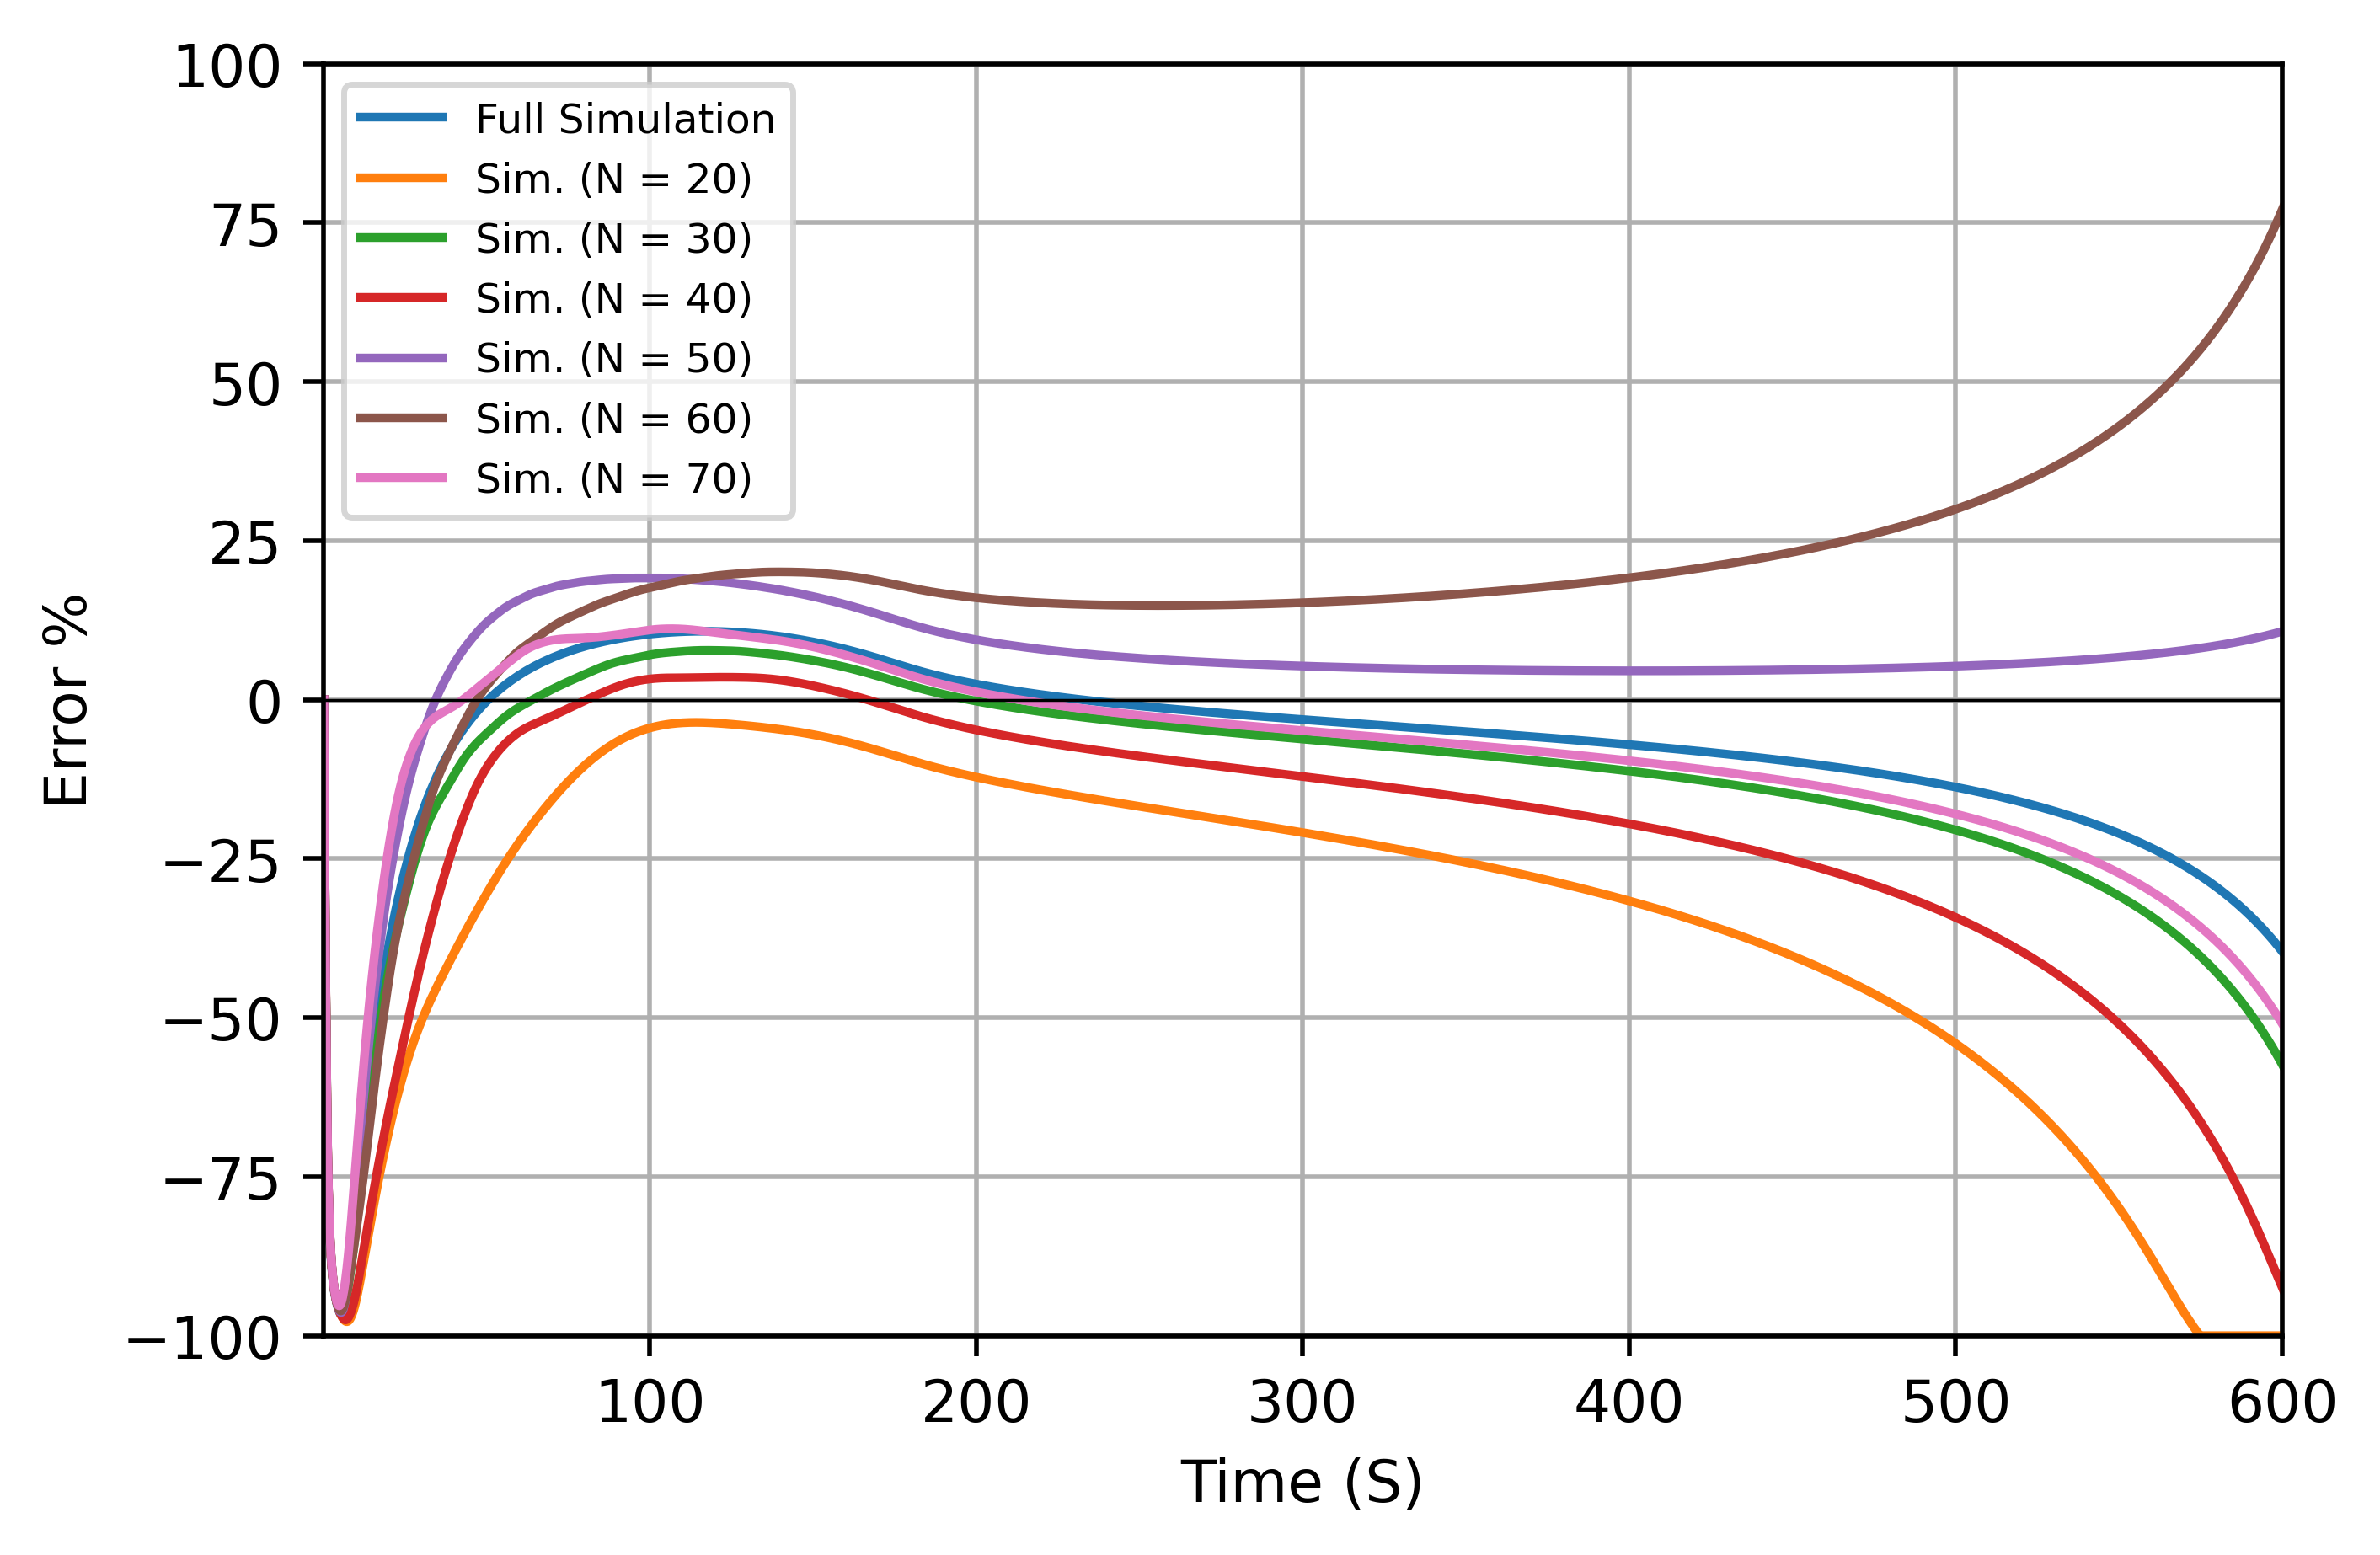

In [37]:
real = datas[0]
sim = datas[1]


datase = [sim - real]
labels = ["error"]

#plotter(datase, times, labels, index=0, xlab="Time (s)", ylab="Error (km)", legend=True, vlines=[], tmn = 0, tmx = int(tmax/inc), Title="Validation of Cross Trajectory")

real = np.array(datas[0])[:][:,0]
sim800 = np.array(datas[1])[:][:,0]
sim20 = np.array(datas[2])[:][:,0]
sim30 = np.array(datas[3])[:][:,0]
sim40 = np.array(datas[4])[:][:,0]
sim50 = np.array(datas[5])[:][:,0]
sim60 = np.array(datas[6])[:][:,0]
sim70 = np.array(datas[7])[:][:,0]



datase = [(sim800 - real)/real]
datase2 = [(sim20 - real)/real]
datase3 = [(sim30 - real)/real]
datase4 = [(sim40 - real)/real]
datase5 = [(sim50 - real)/real]
datase6 = [(sim60 - real)/real]
datase7 = [(sim70 - real)/real]

datases = np.array([datase, datase2, datase3, datase4, datase5, datase6, datase7])
labels = ["Full Simulation", "Sim. (N = 20)", "Sim. (N = 30)", "Sim. (N = 40)", "Sim. (N = 50)",  "Sim. (N = 60)", "Sim. (N = 70)",]


print("Done")
for i in range(len(datases)):
    plt.plot(times, datases[i][0]*100, label=labels[i])
plt.legend(loc="upper left", fontsize=7)
plt.axhline(0, color="black", linewidth=0.5)
plt.ylim(-100, 100)
plt.xlim(.1, 600)
plt.xlabel("Time (S)")
plt.ylabel("Error %")
plt.show()


### Simulation 4: Testing Configuration 4 


In [36]:
a = getA4()
A4snaps, A4burns, A4n = burnAnalysis(a, rate_pixel)

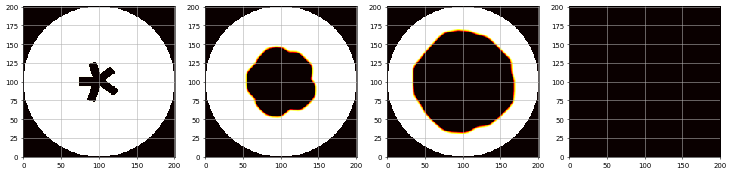

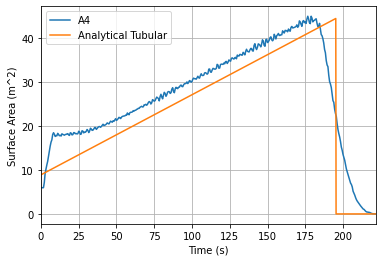

FE Start
FE Complete


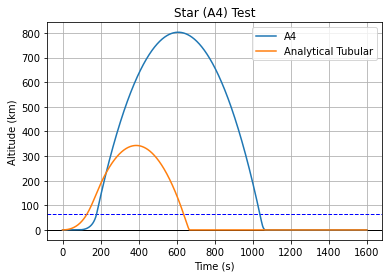

In [37]:
data_A4_SIM, simA4Results = conductTest(getA4(), A4snaps, A4burns, A4n, titleInsert="Star (A4) Test", group="A4")

In [38]:
np.savetxt('Star Data.csv', (times, data_A4_SIM[:, 0]), delimiter=',')

### Simulation 5: Testing Configuration 5


In [39]:
a = getA5()
A5snaps, A5burns, A5n = burnAnalysis(a, rate_pixel)

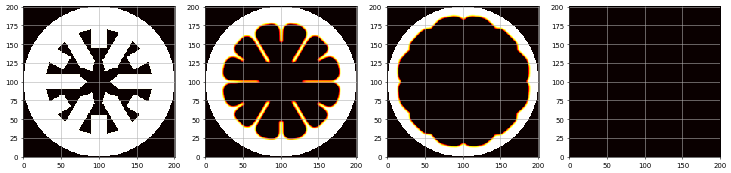

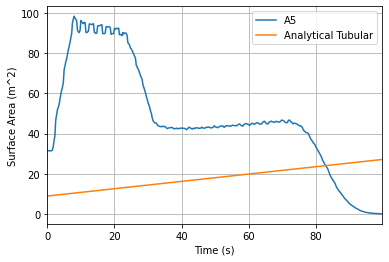

FE Start
FE Complete


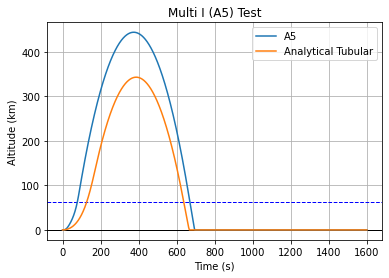

In [41]:
data_A5_SIM, simA5Results = conductTest(getA5(), A5snaps, A5burns, A5n, titleInsert="Multi I (A5) Test", group="A5")

In [44]:
np.savetxt('Multi I Data.csv', (times, data_A5_SIM[:, 0]), delimiter=',')

### Simulation 6: Testing Configuration 6

In [43]:
a = getA6()
A6snaps, A6burns, A6n = burnAnalysis(a, rate_pixel)
print("Complete")

Complete


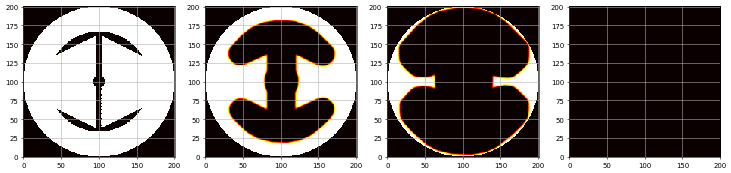

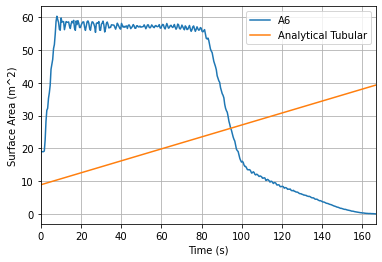

FE Start
FE Complete


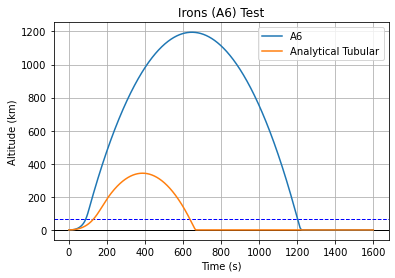

In [45]:
data_A6_SIM, simA6Results = conductTest(getA6(), A6snaps, A6burns, A6n, titleInsert="Irons (A6) Test", group="A6")

In [46]:
np.savetxt('Irons Data.csv', (times, data_A6_SIM[:, 0]), delimiter=',')

In [ ]:
print("INIT")
a = getA7()
A7snaps, A7burns, A7n = burnAnalysis(a, rate_pixel)
print("Completed")

INIT


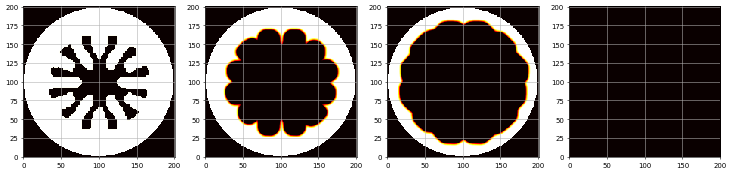

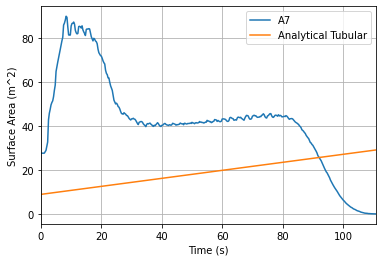

FE Start
FE Complete


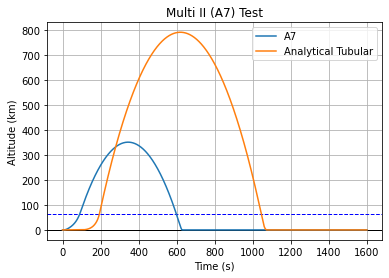

In [226]:
data_A7_SIM, simA7Results = conductTest(getA7(), A7snaps, A7burns, A7n, titleInsert="Multi II (A7) Test", group="A7")

In [ ]:
print("Test")